In [1]:
!pip install netCDF4
!pip install rocketpy

from datetime import datetime
from datetime import date
from datetime import timedelta
from time import process_time, perf_counter, time
import glob

#from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display
tomorrow = date.today() + timedelta(days=1) #test
date_info= (tomorrow.year, tomorrow.month, tomorrow.day, 9) #test

# %config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 14

def inch_to_meter(length):
  return length * 0.0254

def lbs_to_kg(mass):
  return mass * 0.45359237

def lbs_in3_to_kg_m3(density):
  return density * 27679.904710191

def lbft2_to_kgm2(areaMass):
  return areaMass * 0.0421401101

analysis_parameters = {
    # Mass Details
    "rocketMass": (lbs_to_kg(125.25), 0.1), # Rocket's dry mass (kg) and its uncertainty (standard deviation)

    # Propulsion Details - run help(SolidMotor) for more information
    # Sporadic Impulse values of 08/02/22 (impulse, burnOut)
    "impulse": (34391.28, 35.3),                         # Motor total impulse (N*s)
    "burnOut": (9, 0.1),                              # Motor burn out time (s)
    "nozzleRadius": (inch_to_meter(.582)*2/2.0, 0.5/1000),            # Motor's nozzle radius (m)
    "throatRadius": (inch_to_meter(.7715)*2/2.0, 0.001) ,                # Motor's nozzle throat radius (m)
    "grainSeparation": (0.25, 1/1000),                # Motor's grain separation (axial distance between two grains) (m)
    "grainDensity": (lbs_in3_to_kg_m3(0.0565), 0.001),                         # Motor's grain density (kg/m^3)
    "grainOuterRadius": (inch_to_meter(2.625)*2/2.0, 0.375/1000),        # Motor's grain outer radius (m)
    "grainInitialInnerRadius": (inch_to_meter(.875)*2/2.0, 0.375/1000), # Motor's grain inner radius (m)
    "grainInitialHeight": (inch_to_meter(8.25), 1/1000),           # Motor's grain height (m)

    # Aerodynamic Details - run help(Rocket) for more information
    "inertiaI": (lbft2_to_kgm2(5.3695), 0.03675),                       # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "inertiaZ": (lbft2_to_kgm2(1186.5), 0.00007),                       # Rocket's inertia moment relative to its axis (kg*m^2)
    "radius": (inch_to_meter(6.24)/2, 0.001),                      # Rocket's radius (kg*m^2)
    "distanceRocketNozzle": (inch_to_meter(.5),0.001),             # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "distanceRocketPropellant": (-0.571,0.001),         # TBD: Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "powerOffDrag": (0.9081/1.05, 0.033),               # TBD: ultiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10% #Openrocket plot and export, ignition to burnout
    "powerOnDrag": (0.9081/1.05, 0.033),                # TBD: Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10% #burnout to end
    "noseLength": (inch_to_meter(14), 0.001),                       # Rocket's nose cone length (m)
    "noseDistanceToCM": (inch_to_meter(55.693), 0.001),                 # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "finSpan": (inch_to_meter(6.75), 0.0005),                         # Fin span (m)
    "finRootChord": (inch_to_meter(14.25), 0.0005),                    # Fin root chord (m)
    "finTipChord": (inch_to_meter(5.625), 0.0005),                     # Fin tip chord (m)
    "finDistanceToCM": (inch_to_meter(30.531), 0.001),                 # Axial distance between rocket's center of dry mass and nearest point in its fin (m)

    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    # Sporadic Impulse values of 08/02/22 (inclanation, heading, rail length)
    "inclination": (90, 1),                           # Launch rail inclination angle relative to the horizontal plane (degrees)
    "heading": (90, 1),                                 # Launch rail heading relative to north (degrees)
    "railLength": (inch_to_meter(204) , 0.0005),                       # Launch rail length (m)
    "ensembleMember": list(range(10)),                  # Members of the ensemble forecast to be used

    # Parachute Details - run help(Rocket) for more information
    # Sporadic Impulse values of 08/02/22 (CdSDrogue)
    "CdSDrogue": (1.0, 0.07),                     # Drag coefficient times reference area for the drogue chute (m^2)
    "lag_rec": (1.5 , 0.5),                               # Time delay between parachute ejection signal is detected and parachute is inflated (s)

    # Parachute Details - run help(Rocket) for more information
    # Sporadic Impulse values of 08/02/22 (CdSDrogue)
    "CdSMain": (2.56644665, 0.07),                     # Drag coefficient times reference area for the drogue chute (m^2)
    #"lag_rec": (1 , 0.5),                               # Time delay between parachute ejection signal is detected and parachute is inflated (s)

    # Electronic Systems Details - run help(Rocket) for more information
    "lag_se": (3, 0.16)                              # Time delay between sensor signal is received and ejection signal is fired (s)
}



def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}

        for parameter_key, parameter_value in analysis_parameters.items():
            print(f"parameter_key: {parameter_key}, parameter_value: {parameter_value}")
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] =  normal(*parameter_value)
            else:
                flight_setting[parameter_key] =  choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting['lag_rec'] < 0 or  flight_setting['lag_se'] < 0: continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting



def export_flight_data(flight_setting, flight_data, exec_time):
    print(dir(flight_data))
    apogee_time = flight_data.apogee_time
    print(apogee_time)
    [print(flight_data.x(apogee_time))]
    print(flight_data.x_impact)
    print(flight_data.altitude - Env.elevation)

    flight_result = {"outOfRailTime": flight_data.out_of_rail_time,
                 "outOfRailVelocity": flight_data.out_of_rail_velocity,
                     "apogeeX": flight_data.x(apogee_time),
                     "apogeeY": flight_data.y(apogee_time),
                        "apogeeTime": flight_data.apogee_time,
                    "apogeeAltitude": flight_data.altitude - Env.elevation,
                      "impactX": flight_data.x_impact,
                     "impactY": flight_data.y_impact,
                    "impactVelocity": flight_data.impact_velocity,
               "initialStaticMargin": flight_data.rocket.static_margin(0),
             "outOfRailStaticMargin": flight_data.rocket.static_margin(TestFlight.out_of_rail_time),
                 "finalStaticMargin": flight_data.rocket.static_margin(TestFlight.rocket.motor.burn_out_time),
                    "numberOfEvents": len(flight_data.parachute_events),
                     "executionTime": exec_time}

    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(sol[:, [0, 4]], 'Time (s)', 'Vx (m/s)', 'linear', extrapolation="natural")
    flight_data.vy = Function(sol[:, [0, 5]], 'Time (s)', 'Vy (m/s)', 'linear', extrapolation="natural")
    flight_data.vz = Function(sol[:, [0, 6]], 'Time (s)', 'Vz (m/s)', 'linear', extrapolation="natural")
    flight_data.v = (flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2)**0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result['maxVelocity'] = flight_data.maxVel

    # Take care of parachute results
    if len(flight_data.parachute_events) > 0:
        flight_result['drogueTriggerTime'] = flight_data.parachute_events[0][0]
        flight_result['drogueInflatedTime'] = flight_data.parachute_events[0][0] + flight_data.parachute_events[0][1].lag
        flight_result['drogueInflatedVelocity'] = flight_data.v(flight_data.parachute_events[0][0] + flight_data.parachute_events[0][1].lag)
    else:
        flight_result['drogueTriggerTime'] = 0
        flight_result['drogueInflatedTime'] = 0
        flight_result['drogueInflatedVelocity'] = 0

    # Write flight setting and results to file

    dispersion_input_file.write(str(flight_setting) + '\n')
   #dispersion_output_file.write(str(flight_result) + '\n')
    return flight_result

def export_flight_error(flight_setting):
    global dispersion_error_file
    if dispersion_error_file.closed:
        dispersion_error_file = open(str(filename) + '.disp_errors.txt', 'a')
        dispersion_error_file.write(str(flight_setting) + '\n')


import os

# Define the full path to your Downloads directory
output_dir = '/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/rocketpy/valetudo_rocket_v0'

# Ensure the directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Proceed with file operations
filename = os.path.join(output_dir, '/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/rocketpy/valetudo_rocket_v0')

try:
    dispersion_error_file = open(str(filename) + '.disp_errors.txt', 'w')
    dispersion_input_file = open(str(filename) + '.disp_inputs.txt', 'w')
    dispersion_output_file = open(str(filename) + '.disp_outputs.txt', 'w')

    # Replace the test data with actual data
    dispersion_error_file.write("Your actual error messages.\n")
    dispersion_input_file.write("Your actual input data.\n")
    dispersion_output_file.write("Your actual output data.\n")

    # Close the files
    #dispersion_error_file.close()
    #dispersion_input_file.close()
    dispersion_output_file.close()
except Exception as e:
    print(f"An error occurred: {e}")
# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.7/356.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=7018d5319323d503a44ea441dde50a28420a3d77ea9111393493ea6bf2c02080
  Stored in directory: /root/.cache/pip/wheels/72/3e/80/c3e5c354c3cbe62d8c5e4fb63d9e7cdccc7f93399997ae465f
Successfully built simplekml


In [2]:
# Define basic Environment object
#from Environment import Environment
from rocketpy import Environment
from datetime import datetime
from datetime import timedelta


current_time = datetime.now()
yesterday = current_time+timedelta(days = 1)

Env = Environment(
    #date=(2019, 8, 10, 21),
    #date=(2024, 10, 25,  00),

    #date=(2018, 12, 31, 18),
    date = current_time,

    #latitude= -23.36,
    latitude = 32.988528,
    longitude = -106.975056,
    #longitude= -48.011,
    #elevation = "Open-Elevation"
    elevation = 1400
    #railLength = 1.28
)

#Env.set_elevation()
#print("elevation")
#print(Env.elevation)




#########
import xarray as xr

# Load the NetCDF file
#file = "/content/SpaceportAmerica_2018_ERA-5 (1).nc"
#ds = xr.open_dataset(file)

# Print the variable names to identify the correct names
'''print("Available variables in the NetCDF file:")
print(ds.variables)'''

# Define the dictionary with correct variable names based on inspection
'''weather_dict = {
    "time": "time",  # Adjust this if the variable name is different
    "longitude": "longitude",  # Update to match the NetCDF variable name for longitude
    "latitude": "latitude",  # Update to match the NetCDF variable name for latitude
    "altitude": "altitude",  # Adjust this if the variable name is different
    "temperature": "temperature",  # Adjust this if the variable name is different
    "pressure": "pressure",  # Adjust this if the variable name is different
    "humidity": "humidity"  # Adjust this if the variable name is different
}'''

# Print dictionary to verify
'''print("Dictionary for atmospheric model:")
print(weather_dict)'''
dictionary = {
                    "time": "time",
                    "latitude": "lat",
                    "longitude": "lon",
                    "level": "lev",
                    "ensemble": "ens",
                    "temperature": "tmpprs",
                    "surface_geopotential_height": None,
                    "geopotential_height": "hgtprs",
                    "geopotential": None,
                    "u_wind": "ugrdprs",
                    "v_wind": "vgrdprs",
                }
Env.set_atmospheric_model(
        type = "Ensemble",
        #file="/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/rocketpy/valetudo_rocket_v0/SpaceportAmerica_2018_ERA-5 (1).nc",
        file = "GEFS",
        #https://docs.rocketpy.org/en/rel-v1.0.0a1/notebooks/environment_class_usage.html#GEFS
        #file = "CMC",
        #dictionary=weather_dict,
        dictionary = dictionary,
        pressure=None,
        temperature=None,
        wind_u=0,
        wind_v=0,
    )
#Env.maxExpectedHeight = 4572

#print("Height")
#print(Env.height)


'''def set_atmospheric_model(type, file, dictionary):

        weather_data = xr.open_dataset(file)
        print("Available variables in the weather data:")
        print(weather_data.variables)

        # Process the data using the provided dictionary
        time_array = weather_data.variables[dictionary["time"]].values
        lon_array = weather_data.variables[dictionary["longitude"]].values.tolist()
        lat_array = weather_data.variables[dictionary["latitude"]].values.tolist()
        print("Longitude data:", lon_array[:5])  # Print first 5 values for verification
        print("Latitude data:", lat_array[:5])  # Print first 5 values for verification
        # Continue with processing as needed...'''

# Set the atmospheric model with the correct dictionary
#set_atmospheric_model(type="Ensemble", file=file, dictionary=weather_dict)

#########

#Env.set_atmospheric_model(type="Ensemble", file="/content/WHAT", dictionary = "ECMWF")


/usr/local/lib/python3.11/dist-packages/rocketpy/environment/tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2025-02-12 00:00:00 UTC instead.
  warnings.warn(


'def set_atmospheric_model(type, file, dictionary):\n\n        weather_data = xr.open_dataset(file)\n        print("Available variables in the weather data:")\n        print(weather_data.variables)\n\n        # Process the data using the provided dictionary\n        time_array = weather_data.variables[dictionary["time"]].values\n        lon_array = weather_data.variables[dictionary["longitude"]].values.tolist()\n        lat_array = weather_data.variables[dictionary["latitude"]].values.tolist()\n        print("Longitude data:", lon_array[:5])  # Print first 5 values for verification\n        print("Latitude data:", lat_array[:5])  # Print first 5 values for verification\n        # Continue with processing as needed...'


Gravity Details

Acceleration of gravity at surface level:    9.7913 m/s²
Acceleration of gravity at  31.021 km (ASL): 9.7006 m/s²


Launch Site Details

Launch Date: 2025-02-11 23:45:33 UTC
Launch Site Latitude: 32.98853°
Launch Site Longitude: -106.97506°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315459.63 W    3651747.36 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1400.0 m


Atmospheric Model Details

Atmospheric Model Type: Ensemble
Ensemble Maximum Height: 31.021 km
Ensemble Time Period: from 2025-02-11 12:00:00 to 2025-02-27 12:00:00 utc
Ensemble Hour Interval: 6 hrs
Ensemble Latitude Range: From -90.0° to 90.0°
Ensemble Longitude Range: From 0.0° to 359.5°
Number of Ensemble Members: 31
Selected Ensemble Member: 0 (Starts from 0)


Surface Atmospheric Conditions

Surface Wind Speed: 13.81 m/s
Surface Wind Direction: 247.68°
Surface Wind Heading: 67.68°
Surface Pressure: 847.98 hPa
Surface Temperature: 288.87 K
Surface Air Density: 1.023 kg/m³
Surfa

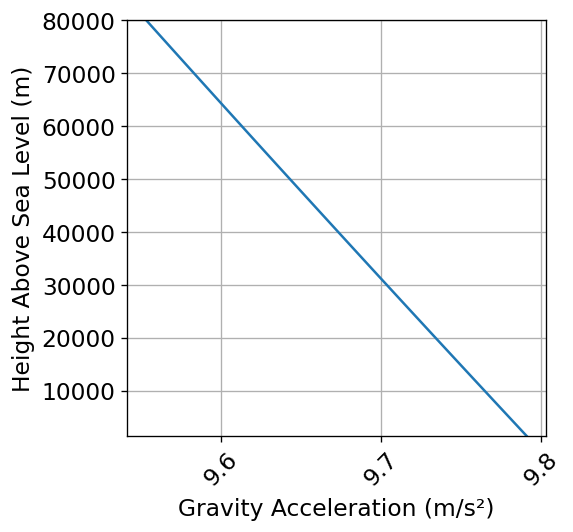



Atmospheric Model Plots


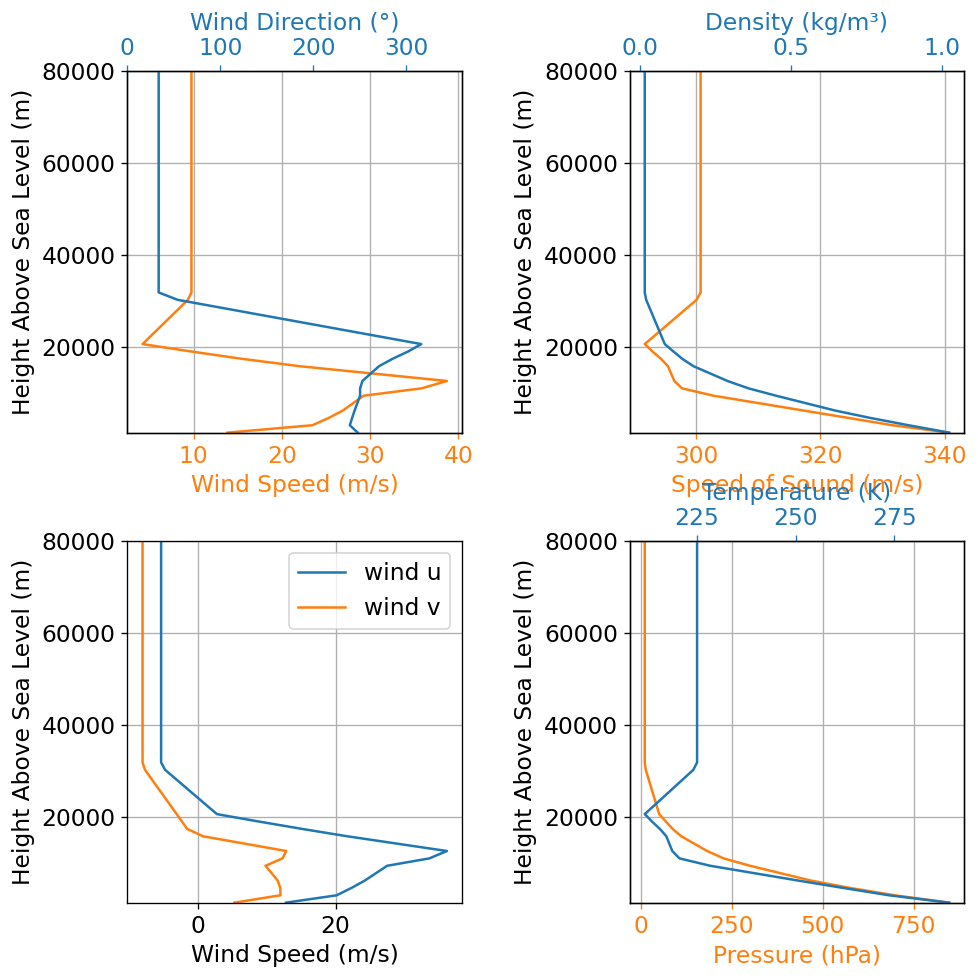



Ensemble Members Comparison


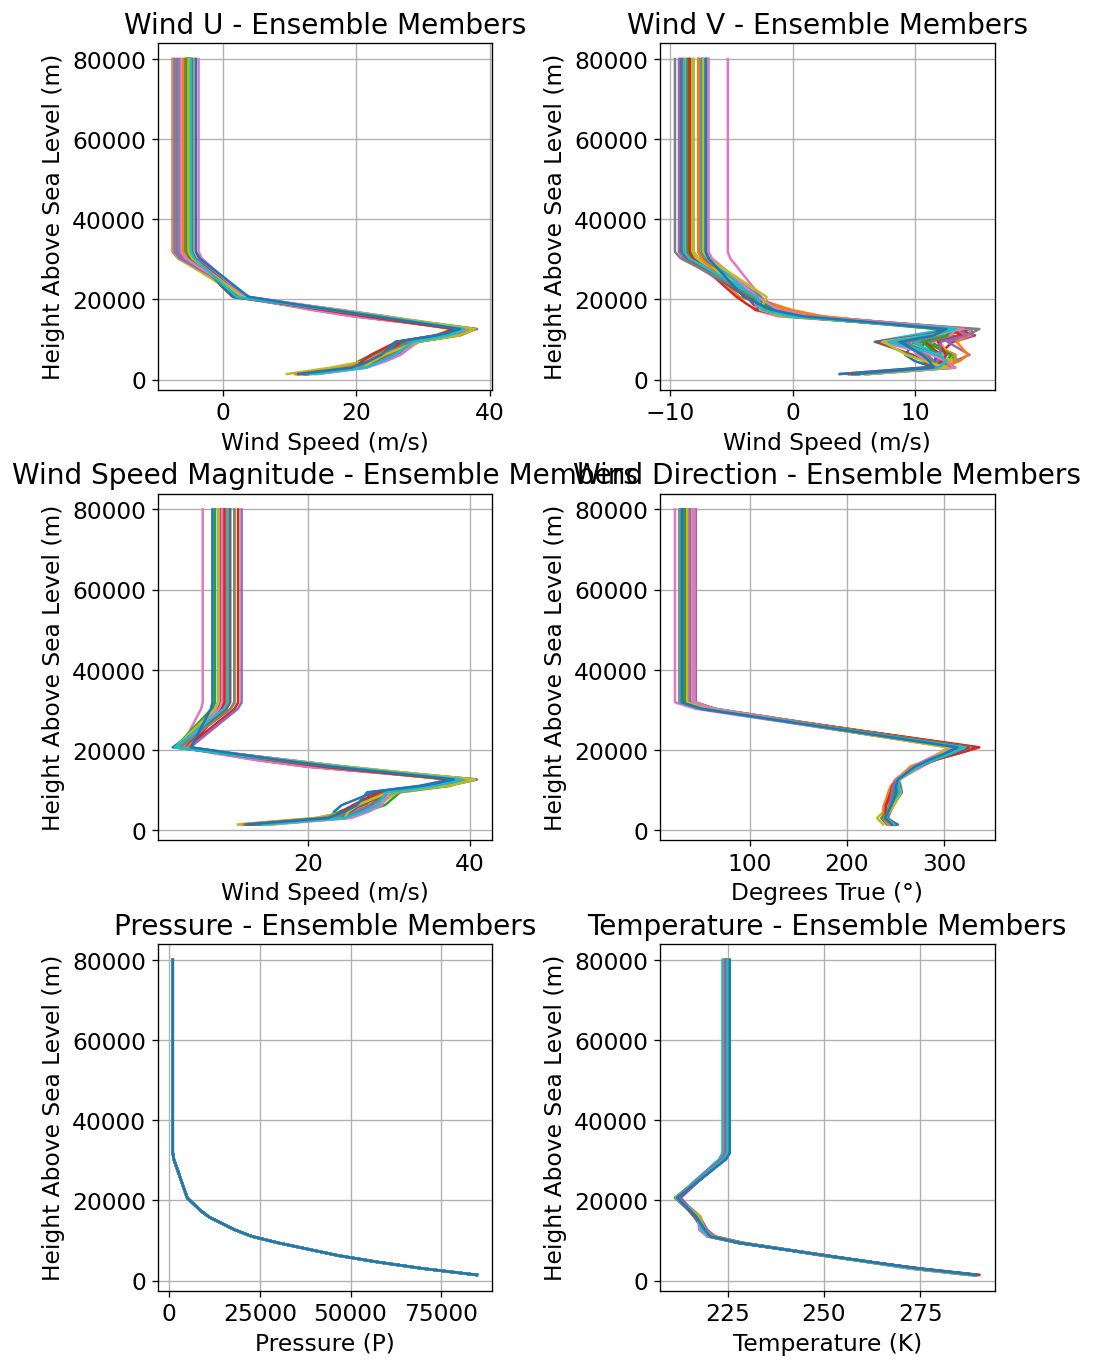

In [3]:
Env.all_info()


In [11]:
# Set up parachutes. This rocket, named Valetudo, only has a drogue chute.
'''def drogueTrigger(p, y):
    # Check if rocket is going down, i.e. if it has passed the apogee
    vertical_velocity = y[5]
    # Return true to activate parachute once the vertical velocity is negative
    return True if vertical_velocity < 0 else False'''
def drogueTrigger(p, h, y):
    # Check if rocket is going down, i.e. if it has passed the apogee
    vertical_velocity = y[5]
    # Return true to activate parachute once the vertical velocity is negative
    return True if vertical_velocity < 0 else False

def mainTrigger(p, y):
    # Check if rocket is going down, i.e. if it has passed the apogee
    vertical_velocity = y[5]
    # Return true to activate parachute once the vertical velocity is negative
    return True if vertical_velocity < 0 and y[2] < 800 else False #Opening based on height

# Iterate over flight settings
out = display('Starting', display_id=True)
number_of_simulations= 100

import datetime
#from Function import Function
#from Rocket import Rocket
from rocketpy import Rocket, Flight, Motor, Parachute, Function, SolidMotor
#from Motor import Motor
#from Flight import Flight
#from Parachute import Parachute

with open(str(filename) + '.disp_outputs.txt', 'w') as file:
      file.close()
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    #env.setDate(datetime.datetime(2018, 12, 31, 18, 00) )
    #env.setLocation(34.5, 252.0)
    #env.processEnsemble(file = file, dictionary = weather_dict)
    #Env.selectEnsembleMember(setting['ensembleMember'])
    Env.select_ensemble_member()
    railLength = 15
    Env.railLength = setting['railLength']

    # Create motor
    SRAD =  SolidMotor(
        #thrust_source= '/content/FormattedTestingData2_3_24 1.eng',
        thrust_source='/content/DukeAEROinME321.eng',
        #thrust_source= '/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/data/motors/mandioca/thrustCurve.csv',
        center_of_dry_mass_position=inch_to_meter(29.9)/2.0,
        burn_time=4.184,
        dry_mass= 6.227,                          # OR
        dry_inertia=(0.125, 0.125, 0.002),

        reshape_thrust_curve=(setting['burnOut'], setting['impulse']),
        nozzle_radius=setting['nozzleRadius'],
        throat_radius=setting['throatRadius'],
        grain_number=6,
        grain_separation=setting['grainSeparation'],
        grain_density=setting['grainDensity'],
        grain_outer_radius=setting['grainOuterRadius'],
        grain_initial_inner_radius=setting['grainInitialInnerRadius'],
        grain_initial_height=setting['grainInitialHeight'],
        grains_center_of_mass_position= 0.3,
        interpolation_method='linear'
        #Orientation ??
    )

    # Create rocket
    Valetudo = Rocket(
        radius=setting['radius'],
        mass=setting['rocketMass'],
        inertia=(23.2, 23.2, 0.087), #change this
        #inertiaI =  23.2,                       # Rocket's inertia moment perpendicular to its axis (kg*m^2)
        #inertiaZ =  0.087,
        power_off_drag= '/content/PowerOFF 1.csv', #power_off_drag='/content/Cd_PowerOff.csv', #???
        #power_off_drag='/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/data/calisto/powerOffDragCurve.csv',
        power_on_drag='/content/PowerON 1.csv', #power_on_drag='/content/Cd_PowerOn.csv',
        #power_on_drag='/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/data/calisto/powerOnDragCurve.csv',


        center_of_mass_without_motor= 1.34, #Change this  # OR
        coordinate_system_orientation="nose_to_tail", ##check
)

    rail_buttons = Valetudo.set_rail_buttons(
        upper_button_position= 2.032,              # VV
        lower_button_position=3.175,             # VV
        angular_position=0,
)
    Valetudo.add_motor(SRAD, position=inch_to_meter(126))

    print("rocketCreated!!!")
    # Edit rocket drag
    Valetudo.power_off_drag *= setting["powerOffDrag"]
    Valetudo.power_on_drag *= setting["powerOnDrag"]
    # Add rocket nose, fins and tail
    NoseCone = Valetudo.add_nose(length=0.3556, kind="ogive", position=0)
    def inch_to_meter(length):
       return length * 0.0254

    FinSet =  Valetudo.add_trapezoidal_fins(
       n=3,
       root_chord=inch_to_meter(12),     # OR
       tip_chord=inch_to_meter(4.5),     # OR
       span=inch_to_meter(5.25),         # OR
       position=inch_to_meter(113),      # OR
        cant_angle=0,)
    # Add parachute
    Drogue = Valetudo.add_parachute(
    "Drogue",
    cd_s=1.0, # NOT CALCULATED, using stock value
    trigger= drogueTrigger, # Trigger at apogee event
    sampling_rate=105, # Not sure
    lag=1.5, # NOT CALCULATED, using stock value
    noise=(0, 8.3, 0.5),) # Not sure

    # Add parachute
    Main = Valetudo.add_parachute(
    "Main",
    cd_s=10.0,  # NOT CALCULATED, using stock value
    trigger=75, # Trigger at 75m
    sampling_rate=105, # Not sure
    lag=1.5,    # NOT CALCULATED, using stock value
    noise=(0, 8.3, 0.5), # Not sure
)
    #Valetudo.all_info()
    # Run trajectory simulation
    print("running flight")
    #try:
    TestFlight = Flight(
        rocket=Valetudo,
        environment=Env,
        inclination=setting['inclination'],
        heading=setting['heading'],
        rail_length=5.1816

    )
    results = export_flight_data(setting, TestFlight, process_time() - start_time)
    '''except Exception as E:
        print(E)
        export_flight_error(setting)'''
    filename = '/content/valetudo_rocket_v0'
    results['apogeeAltitude'] = TestFlight.apogee_state[2]
    with open(str(filename) + '.disp_outputs.txt', 'a') as file:
      file.write(str(results) + '\n')
      file.close()
    print("Flight apogee state")
    print(TestFlight.apogee_state)

    # Register time
    out.update(f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s")

# Done
print("flight done")




'Curent iteration: 000111 | Average Time per Iteration: 2.152744 s'

parameter_key: rocketMass, parameter_value: (56.8124443425, 0.1)
parameter_key: impulse, parameter_value: (34391.28, 35.3)
parameter_key: burnOut, parameter_value: (9, 0.1)
parameter_key: nozzleRadius, parameter_value: (0.014782799999999999, 0.0005)
parameter_key: throatRadius, parameter_value: (0.019596099999999998, 0.001)
parameter_key: grainSeparation, parameter_value: (0.25, 0.001)
parameter_key: grainDensity, parameter_value: (1563.9146161257916, 0.001)
parameter_key: grainOuterRadius, parameter_value: (0.066675, 0.000375)
parameter_key: grainInitialInnerRadius, parameter_value: (0.022224999999999998, 0.000375)
parameter_key: grainInitialHeight, parameter_value: (0.20955, 0.001)
parameter_key: inertiaI, parameter_value: (0.22627132118195004, 0.03675)
parameter_key: inertiaZ, parameter_value: (49.999240633650004, 7e-05)
parameter_key: radius, parameter_value: (0.079248, 0.001)
parameter_key: distanceRocketNozzle, parameter_value: (0.0127, 0.001)
parameter_key: distanceRocketPropell

Nozzle Details
Nozzle Radius: 0.014525088226367647 m
Nozzle Throat Radius: 0.01871504718902705 m

Grain Details
Number of Grains: 6
Grain Spacing: 0.2503510322052452 m
Grain Density: 1563.9151271082103 kg/m3
Grain Outer Radius: 0.06645185159794258 m
Grain Inner Radius: 0.021326600545664782 m
Grain Height: 0.2080493906706405 m
Grain Volume: 0.003 m3
Grain Mass: 4.049 kg

Motor Details
Total Burning Time: 8.923480497771376 s
Total Propellant Mass: 24.293 kg
Structural Mass Ratio: 0.204
Average Propellant Exhaust Velocity: 1416.097 m/s
Average Thrust: 3855.200 N
Maximum Thrust: 4651.976621343416 N at 3.5431466682327524 s after ignition.
Total Impulse: 34401.803 Ns



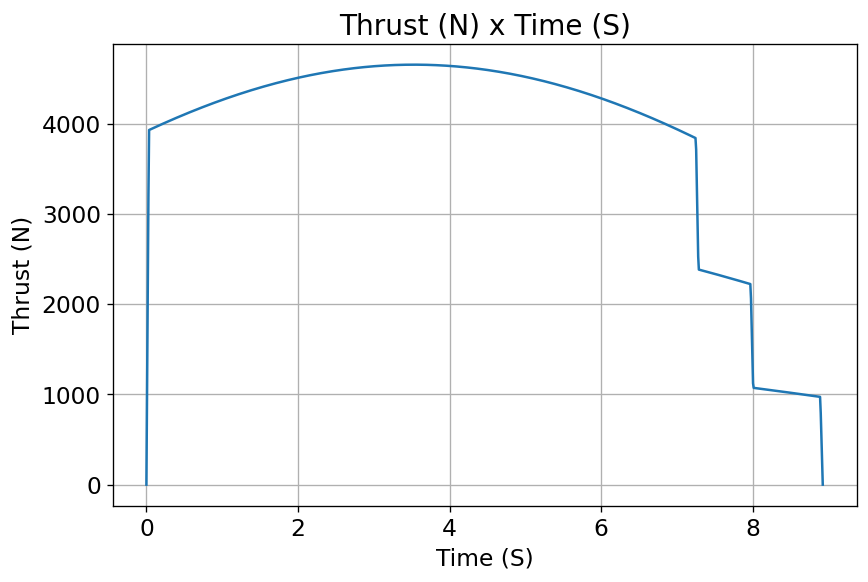


Inertia Details

Rocket Mass: 56.742 kg (without motor)
Rocket Dry Mass: 62.969 kg (with unloaded motor)
Rocket Loaded Mass: 87.262 kg
Rocket Structural Mass Ratio: 0.722
Rocket Inertia (with unloaded motor) 11: 35.627 kg*m2
Rocket Inertia (with unloaded motor) 22: 35.627 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.089 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.07788812607048491 m
Rocket Frontal Area: 0.019059 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.146 m
Rocket Center of Dry Mass - Nozzle Exit: 1.714 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.414 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.394 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.303/rad

Center o

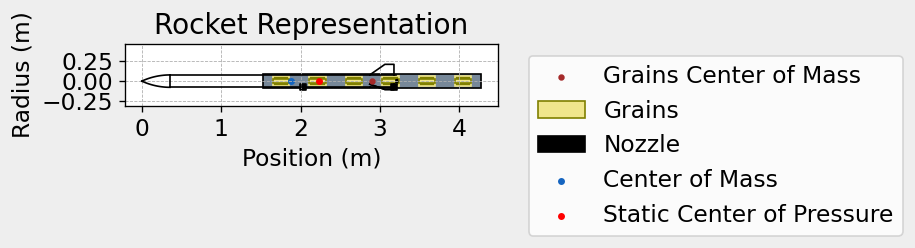


Mass Plots
----------------------------------------


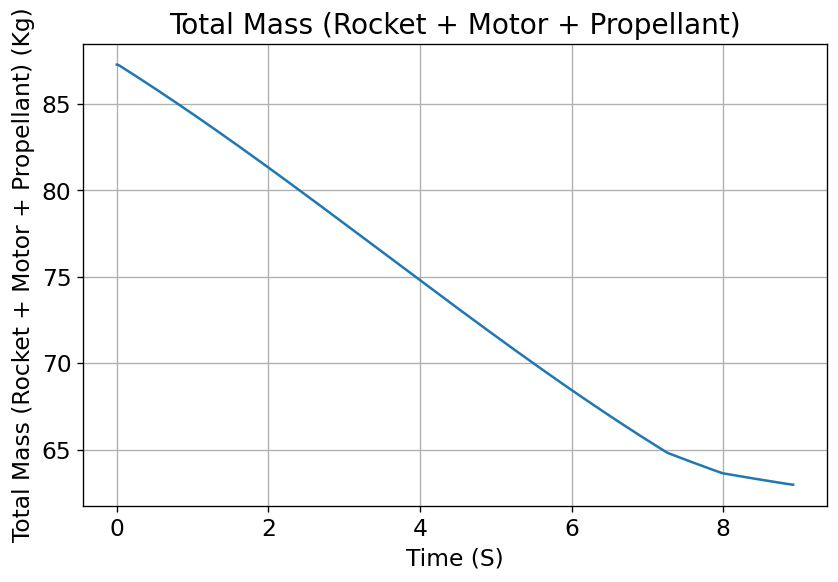

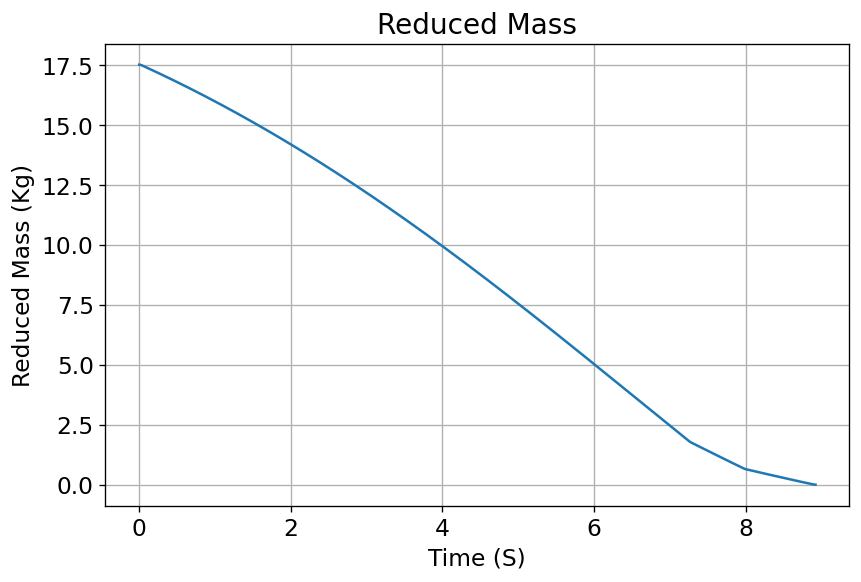


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


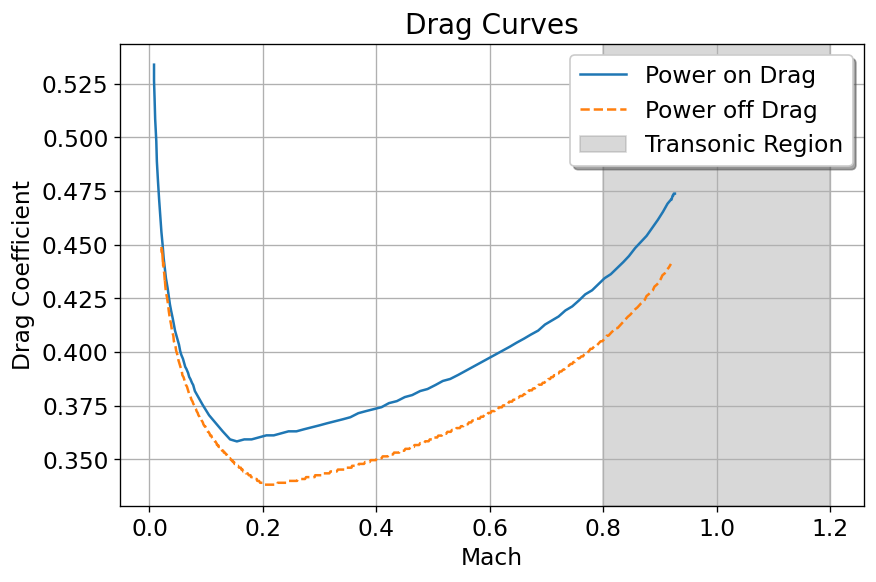


Stability Plots
--------------------


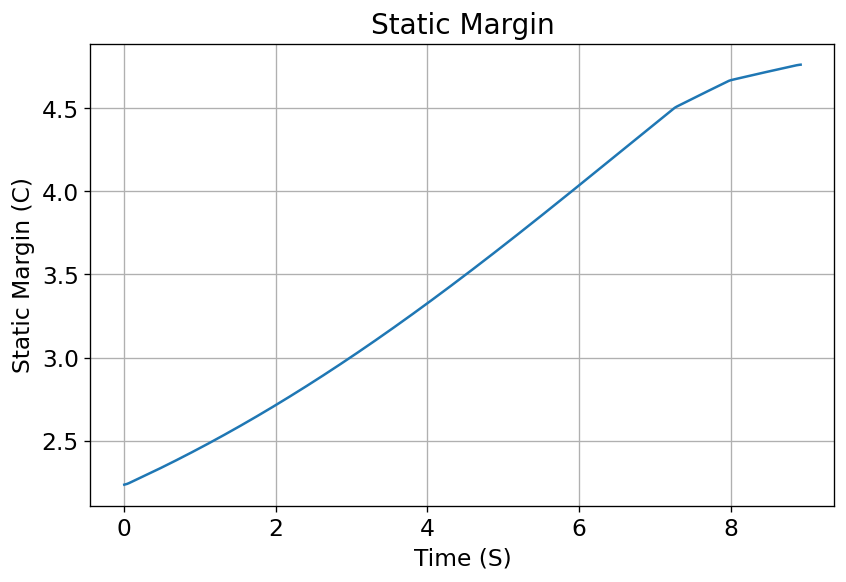

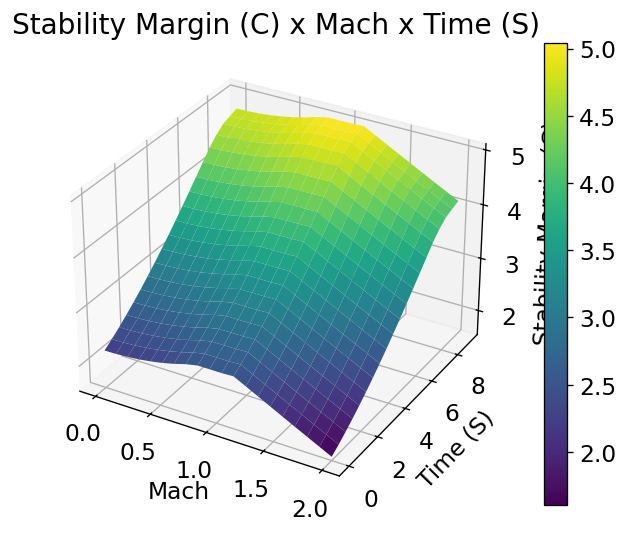


Thrust-to-Weight Plot
----------------------------------------


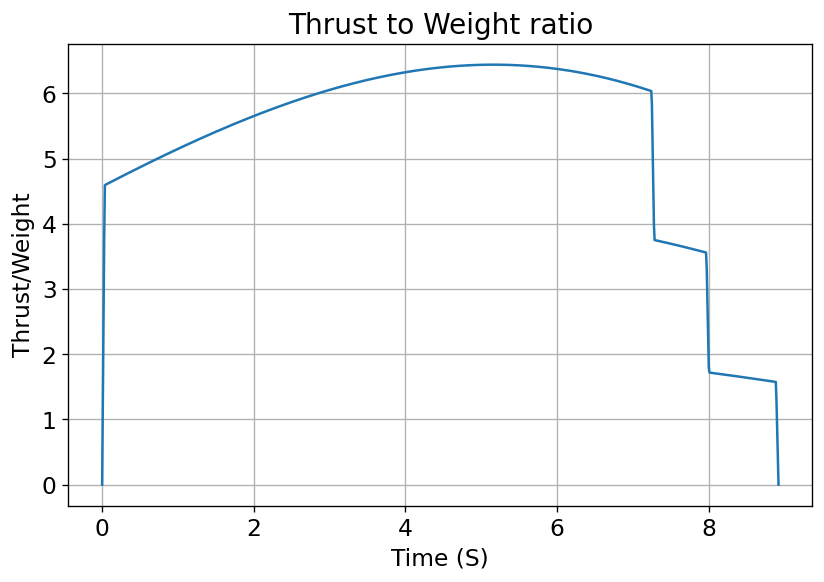


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 1400.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.710 | e1: 0.002 | e2: -0.002 | e3: -0.704
Euler Angles - Spin φ : -180.00° | Nutation θ: -0.31° | Precession ψ: 90.51°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.236 c


Surface Wind Conditions

Frontal Surface Wind Speed: 12.81 m/s
Lateral Surface Wind Speed: 5.15 m/s


Launch Rail

Launch Rail Length: 5.1816 m
Launch Rail Inclination: 90.31°
Launch Rail Heading: 89.49°


Rail Departure State

Rail Departure Time: 0.492 s
Rail Departure Velocity: 17.244 m/s
Rail Departure Stability Margin: 2.340 c
Rail Departure Angle of Attack: 38.624°
Rail Departure Thrust-Weight Ratio: 4.863
Rail Departure Reynolds Number: 1.969e+05


Burn out State

Burn out time: 8.923 s
Altitude at burn out: 3003.843 m (ASL) | 1603.843 m (AGL)
Rocket speed at burn out: 347.569 m/s
Freest

In [12]:




#filename = '/Users/alexzhang/Desktop/projects/Aero/MonteCarlo/RocketPy-Jupiter/rocketpy/valetudo_rocket_v0'
filename = '/content/valetudo_rocket_v0'

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {"outOfRailTime": [],
                  "outOfRailVelocity": [],
                         "apogeeTime": [],
                     "apogeeAltitude": [],
                            "apogeeX": [],
                            "apogeeY": [],
                         "impactTime": [],
                            "impactX": [],
                            "impactY": [],
                     "impactVelocity": [],
                "initialStaticMargin": [],
              "outOfRailStaticMargin": [],
                  "finalStaticMargin": [],
                     "numberOfEvents": [],
                        "maxVelocity": [],
                  "drogueTriggerTime": [],
                 "drogueInflatedTime": [],
             "drogueInflatedVelocity": [],
                      "executionTime": []}



#Info
SRAD.info()
Valetudo.all_info()
TestFlight.info()
#TestFlight.all_info()



Flight resluts
{'outOfRailTime': 0.49206198163638437, 'outOfRailVelocity': 17.244140056821905, 'apogeeX': -3831.6337824080124, 'apogeeY': -1618.1081300968503, 'apogeeTime': 35.80798189825518, 'apogeeAltitude': 6830.776166253823, 'impactX': -1461.975775932422, 'impactY': -326.84831258557205, 'impactVelocity': -13.076587811513644, 'initialStaticMargin': 2.235424956581569, 'outOfRailStaticMargin': 2.338131534714065, 'finalStaticMargin': 4.762414372192169, 'numberOfEvents': 2, 'executionTime': 2.341220582999995, 'maxVelocity': 348.63310519697154, 'drogueTriggerTime': 35.80952380952381, 'drogueInflatedTime': 37.30952380952381, 'drogueInflatedVelocity': 115.59867166363718}
Number of simulations:  100
Out of Rail Time -         Mean Value: 0.496 s
Out of Rail Time - Standard Deviation: 0.004 s


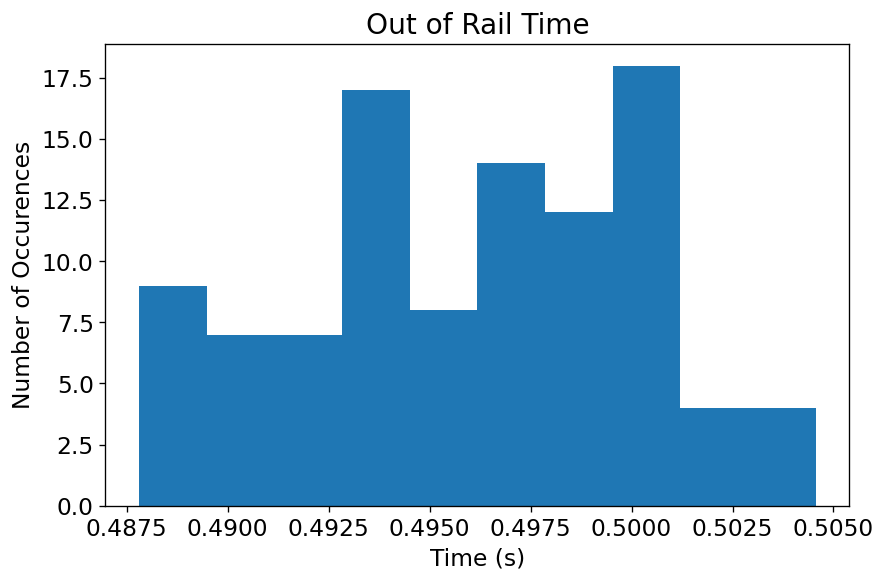

Out of Rail Velocity -         Mean Value: 17.176 m/s
Out of Rail Velocity - Standard Deviation: 0.145 m/s


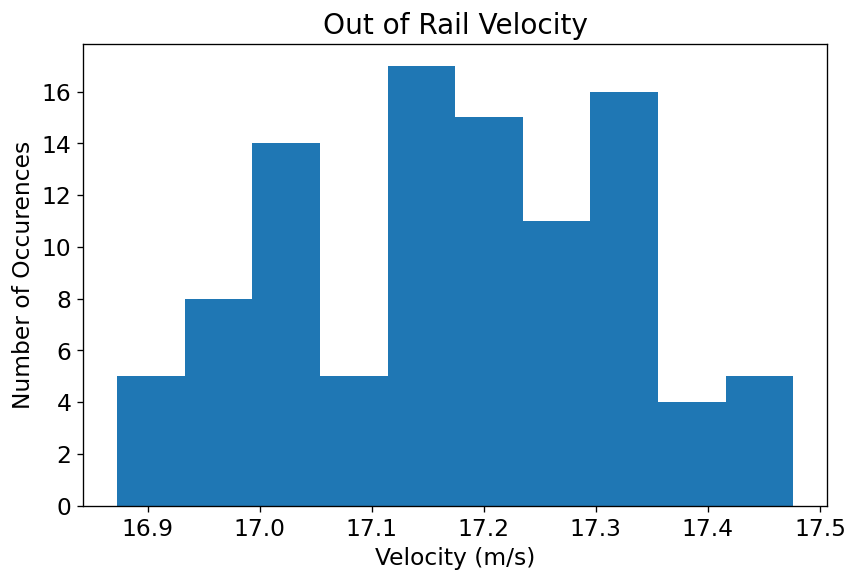

Apogee Time -         Mean Value: 35.886 s
Apogee Time - Standard Deviation: 0.368 s


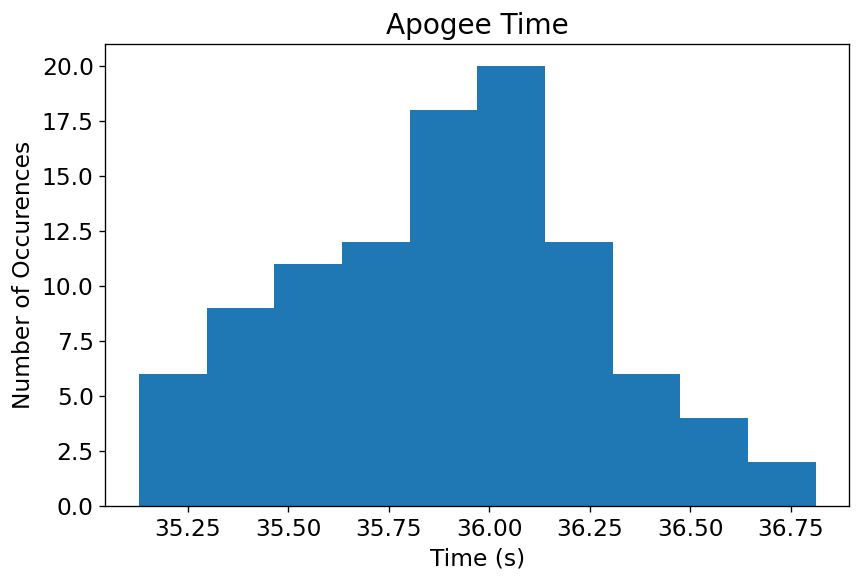

Apogee Altitude -         Mean Value: 6846.687 m
Apogee Altitude - Standard Deviation: 115.797 m


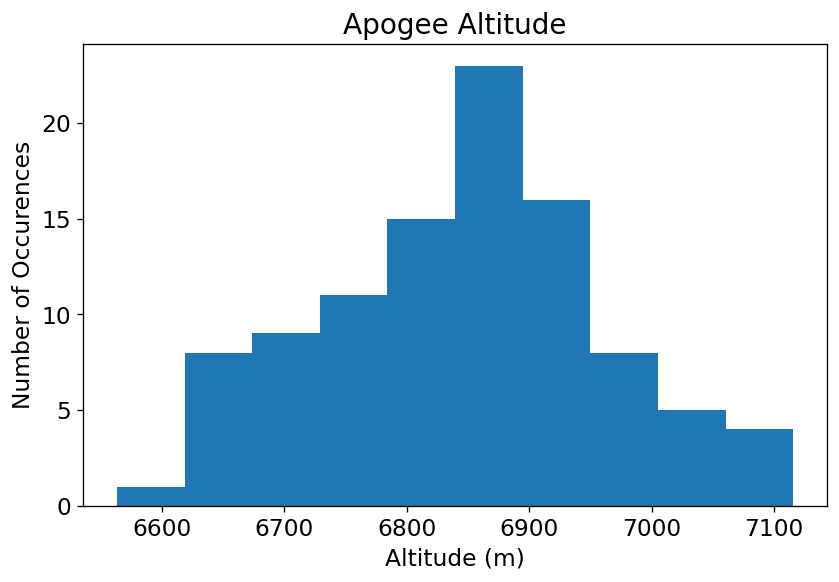

Apogee X Position -         Mean Value: -3774.877 m
Apogee X Position - Standard Deviation: 195.697 m


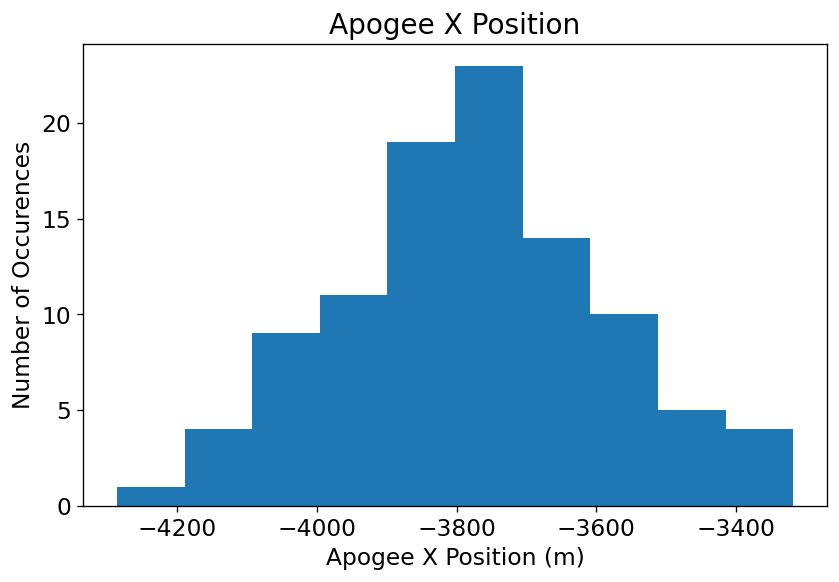

Apogee Y Position -         Mean Value: -1634.540 m
Apogee Y Position - Standard Deviation: 32.945 m


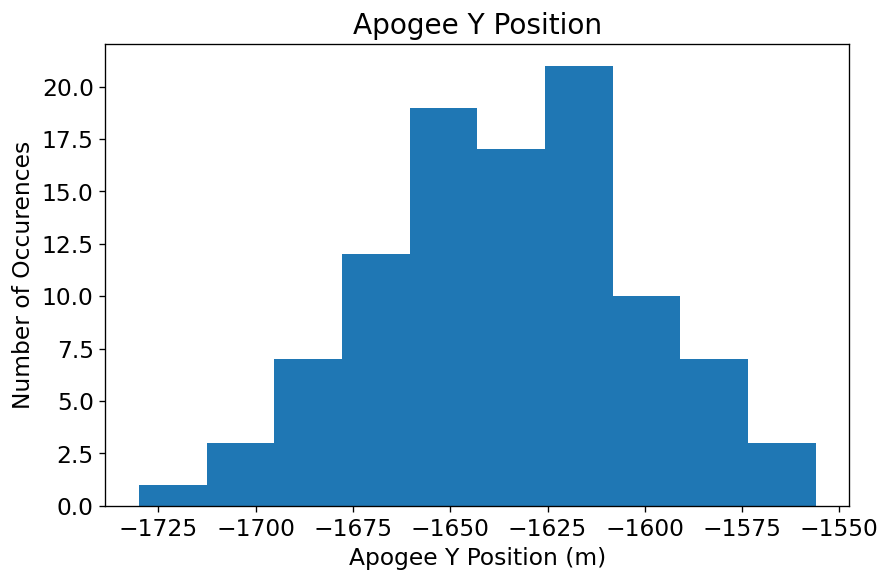

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Impact Time -         Mean Value: nan s
Impact Time - Standard Deviation: nan s


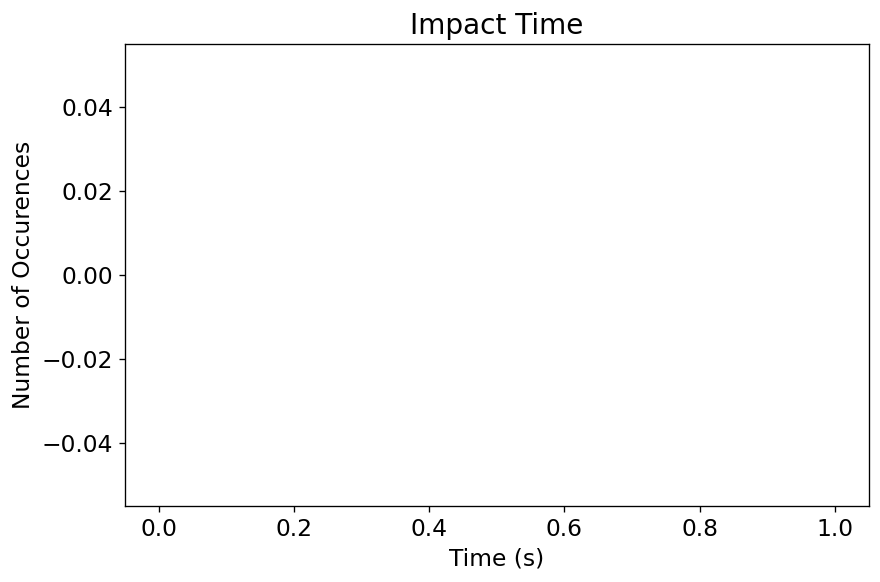

Impact X Position -         Mean Value: -1393.365 m
Impact X Position - Standard Deviation: 260.829 m


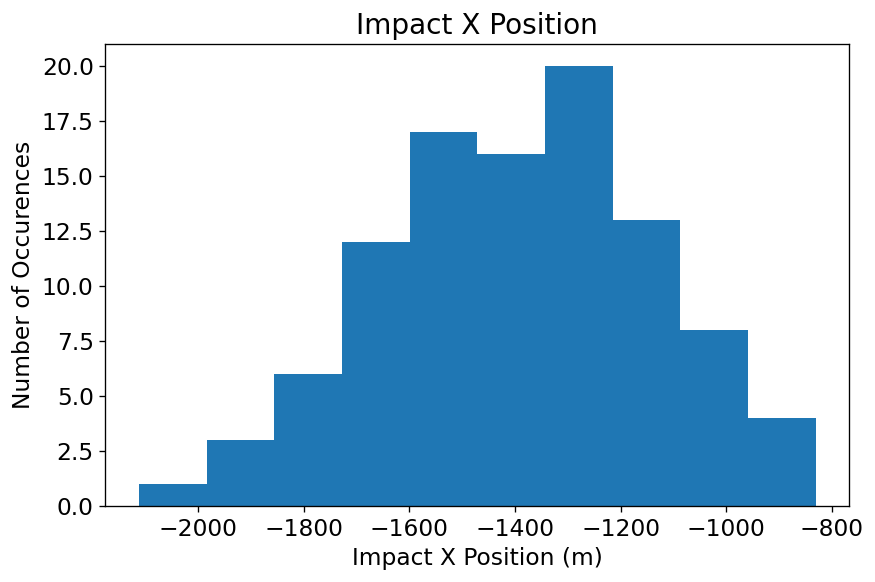

Impact Y Position -         Mean Value: -344.263 m
Impact Y Position - Standard Deviation: 25.273 m


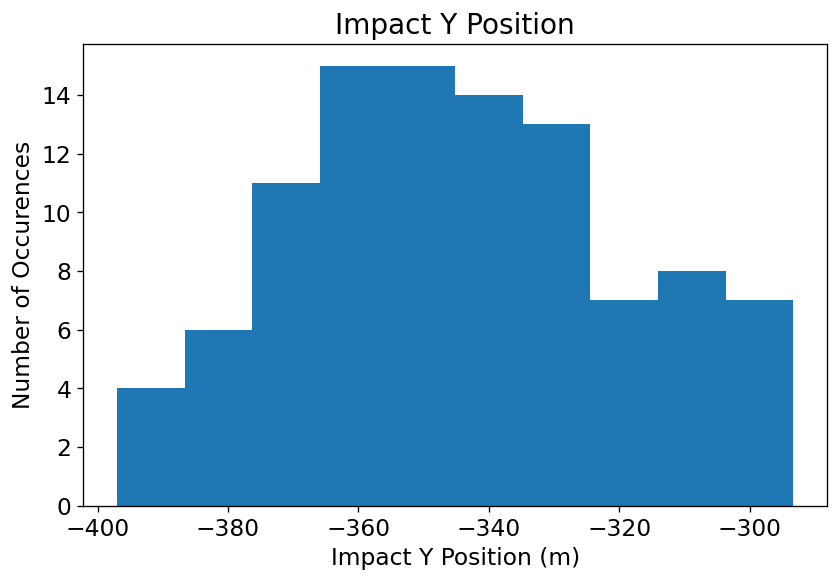

Impact Velocity -         Mean Value: -14.534 m/s
Impact Velocity - Standard Deviation: 5.138 m/s


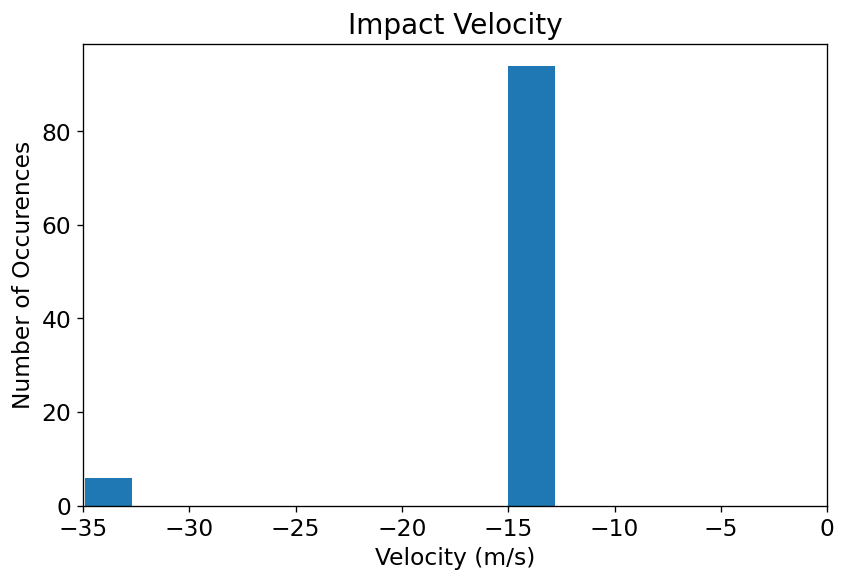

Initial Static Margin -             Mean Value: 2.085 c
Initial Static Margin -     Standard Deviation: 0.122 c
Out of Rail Static Margin -         Mean Value: 2.186 c
Out of Rail Static Margin - Standard Deviation: 0.123 c
Final Static Margin -               Mean Value: 4.576 c
Final Static Margin -       Standard Deviation: 0.151 c


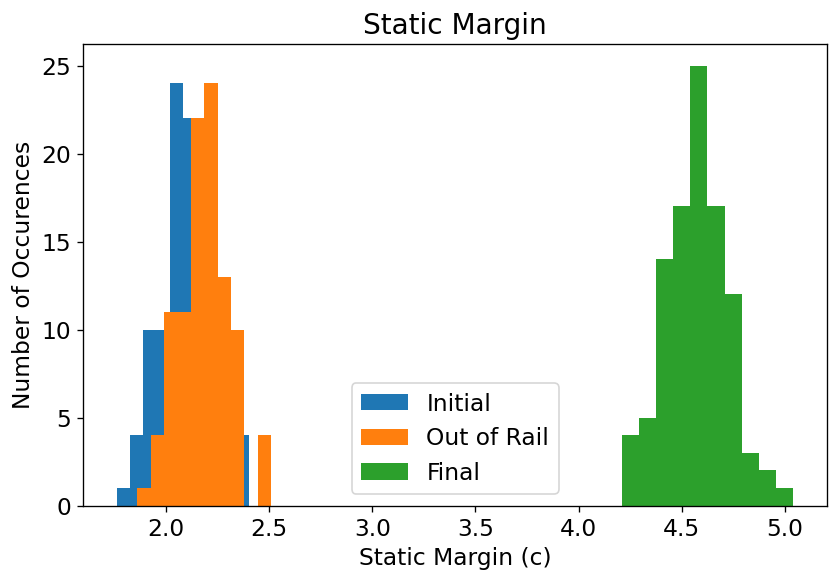

Maximum Velocity -         Mean Value: 348.264 m/s
Maximum Velocity - Standard Deviation: 1.741 m/s


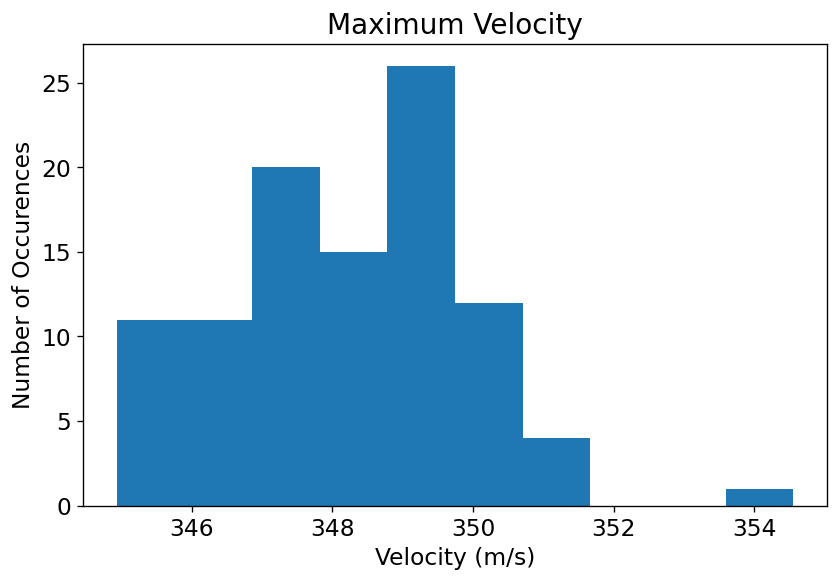

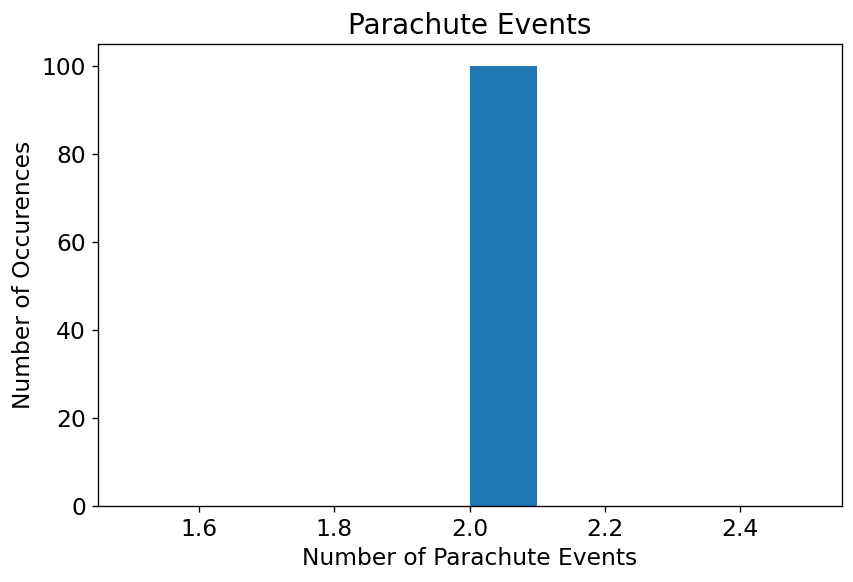

Drogue Parachute Trigger Time -         Mean Value: 35.891 s
Drogue Parachute Trigger Time - Standard Deviation: 0.368 s


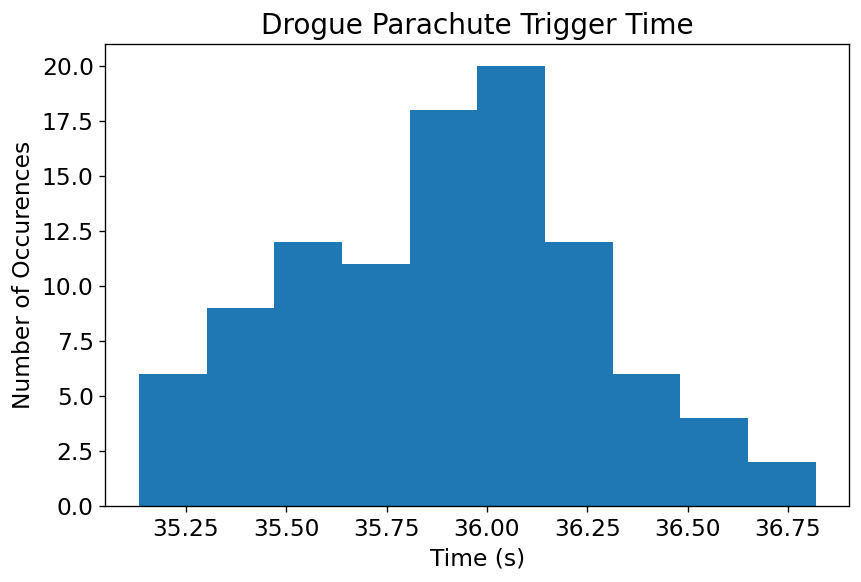

Drogue Parachute Fully Inflated Time -         Mean Value: 37.391 s
Drogue Parachute Fully Inflated Time - Standard Deviation: 0.368 s


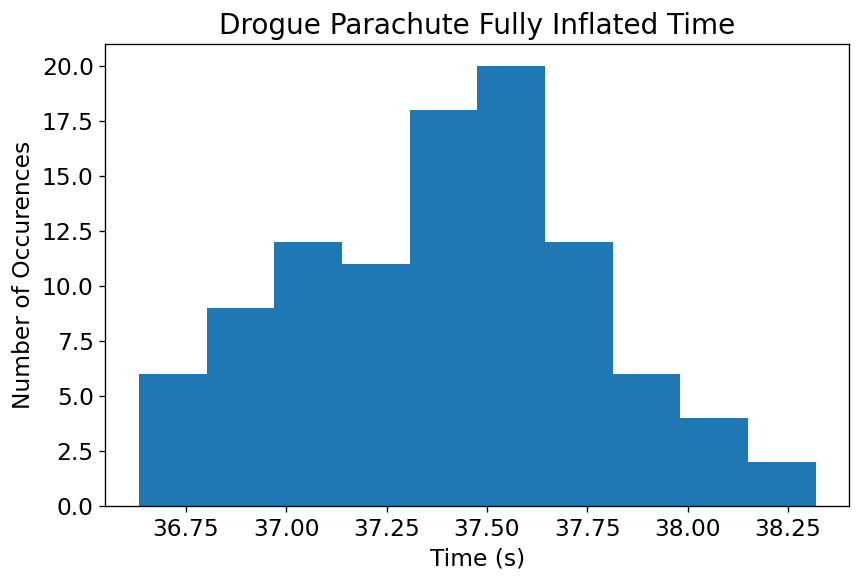

In [13]:
# Get all dispersion results
# Get file
print("Flight resluts")
print(results)
#dispersion_output_file = open(str(filename) + '.disp_outputs.txt', 'w')



#dispersion_output_file.write(str(results) + '\n')


dispersion_output_file = open(str(filename)+'.disp_outputs.txt', 'r+')

#Need to clear dispersion output file and then write to it



# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != '{': continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print('Number of simulations: ', N)

print(f'Out of Rail Time -         Mean Value: {np.mean(dispersion_results["outOfRailTime"]):0.3f} s')
print(f'Out of Rail Time - Standard Deviation: {np.std(dispersion_results["outOfRailTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["outOfRailTime"], bins=int(N**0.5))
plt.title('Out of Rail Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

# You can also use Plotly instead of Matplotlib if you wish!
# import plotly.express as px
# fig1 = px.histogram(
#     x=dispersion_results["outOfRailTime"],
#     title='Out of Rail Time',
#     nbins=int(N**0.5)
# )
# fig1.update_layout(
#     xaxis_title_text='Time (s)',
#     yaxis_title_text='Number of occurences'
# )

#Out of rail velocity
print(f'Out of Rail Velocity -         Mean Value: {np.mean(dispersion_results["outOfRailVelocity"]):0.3f} m/s')
print(f'Out of Rail Velocity - Standard Deviation: {np.std(dispersion_results["outOfRailVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["outOfRailVelocity"], bins=int(N**0.5))
plt.title('Out of Rail Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

#Apogee Time
print(f'Apogee Time -         Mean Value: {np.mean(dispersion_results["apogeeTime"]):0.3f} s')
print(f'Apogee Time - Standard Deviation: {np.std(dispersion_results["apogeeTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["apogeeTime"], bins=int(N**0.5))
plt.title('Apogee Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

#Apogee Altitude
print(f'Apogee Altitude -         Mean Value: {np.mean(dispersion_results["apogeeAltitude"]):0.3f} m')
print(f'Apogee Altitude - Standard Deviation: {np.std(dispersion_results["apogeeAltitude"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title('Apogee Altitude')
plt.xlabel('Altitude (m)')
plt.ylabel('Number of Occurences')
plt.show()

# Real measured apogee for Valetudo = 860 m

#Apogee X Position
print(f'Apogee X Position -         Mean Value: {np.mean(dispersion_results["apogeeX"]):0.3f} m')
print(f'Apogee X Position - Standard Deviation: {np.std(dispersion_results["apogeeX"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["apogeeX"], bins=int(N**0.5))
plt.title('Apogee X Position')
plt.xlabel('Apogee X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

#Apogee Y Position
print(f'Apogee Y Position -         Mean Value: {np.mean(dispersion_results["apogeeY"]):0.3f} m')
print(f'Apogee Y Position - Standard Deviation: {np.std(dispersion_results["apogeeY"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["apogeeY"], bins=int(N**0.5))
plt.title('Apogee Y Position')
plt.xlabel('Apogee Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

#Impact Time
print(f'Impact Time -         Mean Value: {np.mean(dispersion_results["impactTime"]):0.3f} s')
print(f'Impact Time - Standard Deviation: {np.std(dispersion_results["impactTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["impactTime"], bins=int(N**0.5))
plt.title('Impact Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

#Impact X Position
print(f'Impact X Position -         Mean Value: {np.mean(dispersion_results["impactX"]):0.3f} m')
print(f'Impact X Position - Standard Deviation: {np.std(dispersion_results["impactX"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["impactX"], bins=int(N**0.5))
plt.title('Impact X Position')
plt.xlabel('Impact X Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

#Impact Y Position
print(f'Impact Y Position -         Mean Value: {np.mean(dispersion_results["impactY"]):0.3f} m')
print(f'Impact Y Position - Standard Deviation: {np.std(dispersion_results["impactY"]):0.3f} m')

plt.figure()
plt.hist(dispersion_results["impactY"], bins=int(N**0.5))
plt.title('Impact Y Position')
plt.xlabel('Impact Y Position (m)')
plt.ylabel('Number of Occurences')
plt.show()

#Impact Velocity
print(f'Impact Velocity -         Mean Value: {np.mean(dispersion_results["impactVelocity"]):0.3f} m/s')
print(f'Impact Velocity - Standard Deviation: {np.std(dispersion_results["impactVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["impactVelocity"], bins=int(N**0.5))
plt.title('Impact Velocity')
# plt.grid()
plt.xlim(-35,0)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

#Static Margin
print(f'Initial Static Margin -             Mean Value: {np.mean(dispersion_results["initialStaticMargin"]):0.3f} c')
print(f'Initial Static Margin -     Standard Deviation: {np.std(dispersion_results["initialStaticMargin"]):0.3f} c')

print(f'Out of Rail Static Margin -         Mean Value: {np.mean(dispersion_results["outOfRailStaticMargin"]):0.3f} c')
print(f'Out of Rail Static Margin - Standard Deviation: {np.std(dispersion_results["outOfRailStaticMargin"]):0.3f} c')

print(f'Final Static Margin -               Mean Value: {np.mean(dispersion_results["finalStaticMargin"]):0.3f} c')
print(f'Final Static Margin -       Standard Deviation: {np.std(dispersion_results["finalStaticMargin"]):0.3f} c')

plt.figure()
plt.hist(dispersion_results["initialStaticMargin"], label='Initial', bins=int(N**0.5))
plt.hist(dispersion_results["outOfRailStaticMargin"], label='Out of Rail', bins=int(N**0.5))
plt.hist(dispersion_results["finalStaticMargin"], label='Final', bins=int(N**0.5))
plt.legend()
plt.title('Static Margin')
plt.xlabel('Static Margin (c)')
plt.ylabel('Number of Occurences')
plt.show()

#Maximum Velocity
print(f'Maximum Velocity -         Mean Value: {np.mean(dispersion_results["maxVelocity"]):0.3f} m/s')
print(f'Maximum Velocity - Standard Deviation: {np.std(dispersion_results["maxVelocity"]):0.3f} m/s')

plt.figure()
plt.hist(dispersion_results["maxVelocity"], bins=int(N**0.5))
plt.title('Maximum Velocity')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Number of Occurences')
plt.show()

#NUmber of Parachute Events
plt.figure()
plt.hist(dispersion_results["numberOfEvents"])
plt.title('Parachute Events')
plt.xlabel('Number of Parachute Events')
plt.ylabel('Number of Occurences')
plt.show()

#Drogue Parachute Trigger TIme
print(f'Drogue Parachute Trigger Time -         Mean Value: {np.mean(dispersion_results["drogueTriggerTime"]):0.3f} s')
print(f'Drogue Parachute Trigger Time - Standard Deviation: {np.std(dispersion_results["drogueTriggerTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["drogueTriggerTime"], bins=int(N**0.5))
plt.title('Drogue Parachute Trigger Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()

#Drogue Parachute Fully Inflated Time
print(f'Drogue Parachute Fully Inflated Time -         Mean Value: {np.mean(dispersion_results["drogueInflatedTime"]):0.3f} s')
print(f'Drogue Parachute Fully Inflated Time - Standard Deviation: {np.std(dispersion_results["drogueInflatedTime"]):0.3f} s')

plt.figure()
plt.hist(dispersion_results["drogueInflatedTime"], bins=int(N**0.5))
plt.title('Drogue Parachute Fully Inflated Time')
plt.xlabel('Time (s)')
plt.ylabel('Number of Occurences')
plt.show()


<ipython-input-14-a6e93ef8de44>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread("/content/Valetudo_basemap_final.jpg")


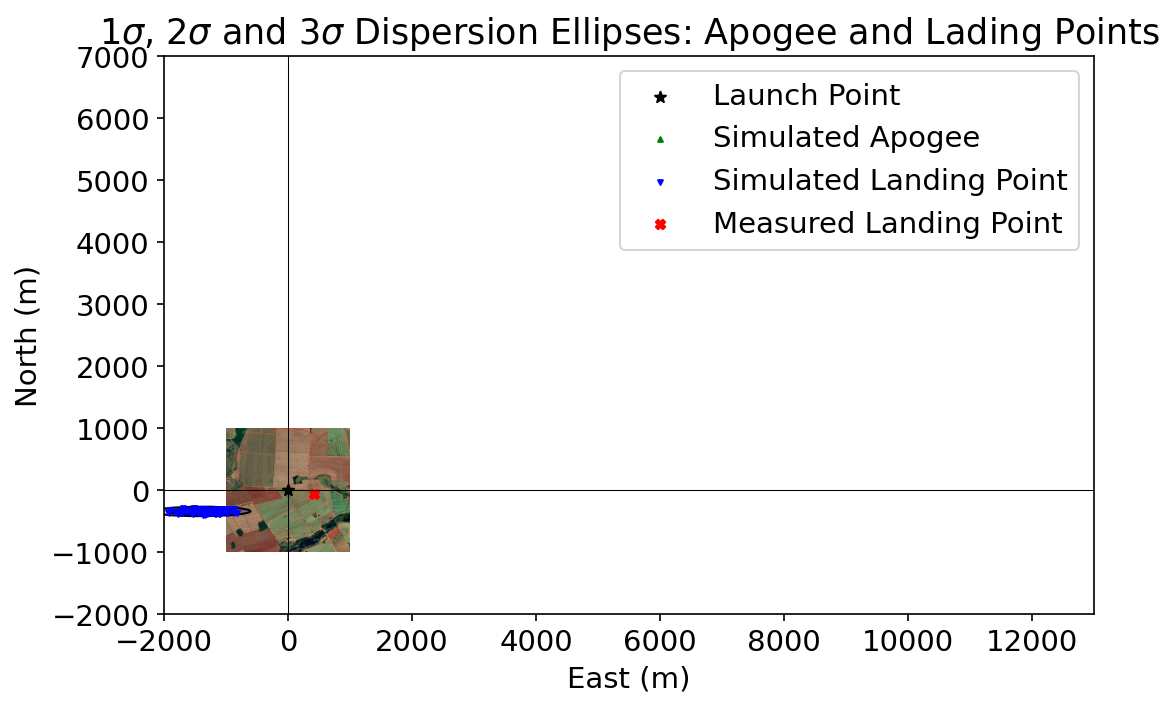

In [14]:

#Error Ellipses
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("/content/Valetudo_basemap_final.jpg")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results['apogeeX'])
apogeeY = np.array(dispersion_results['apogeeY'])
impactX = np.array(dispersion_results['impactX'])
impactY = np.array(dispersion_results['impactY'])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:,0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(xy=(np.mean(impactX), np.mean(impactY)),
                  width=impactW*j, height=impactH*j,
                  angle=impactTheta, color='black')
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:,0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(xy=(np.mean(apogeeX), np.mean(apogeeY)),
                  width=apogeeW*j, height=apogeeH*j,
                  angle=apogeeTheta, color='black')
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)

# Draw launch point
plt.scatter(0, 0, s=30, marker='*', color='black', label='Launch Point')
# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=5, marker='^', color='green', label='Simulated Apogee')
# Draw impact points
plt.scatter(impactX, impactY, s=5, marker='v', color='blue', label='Simulated Landing Point')
# Draw real landing point
plt.scatter(411.89, -61.07, s=20, marker='X', color='red', label='Measured Landing Point')

plt.legend()

# Add title and labels to plot
ax.set_title('1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points')
ax.set_ylabel('North (m)')
ax.set_xlabel('East (m)')

# Add background image to plot
# You can translate the basemap by changing dx and dy (in meters)
dx = 0
dy = 0
plt.imshow(img,zorder=0, extent=[-1000-dx, 1000-dx, -1000-dy, 1000-dy])
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-2000, 13000)
plt.ylim(-2000, 7000)

# Save plot and show result
plt.savefig(str(filename)+ '.pdf', bbox_inches='tight', pad_inches=0)
plt.savefig(str(filename)+ '.svg', bbox_inches='tight', pad_inches=0)
plt.show()



Trajectory 3d Plot



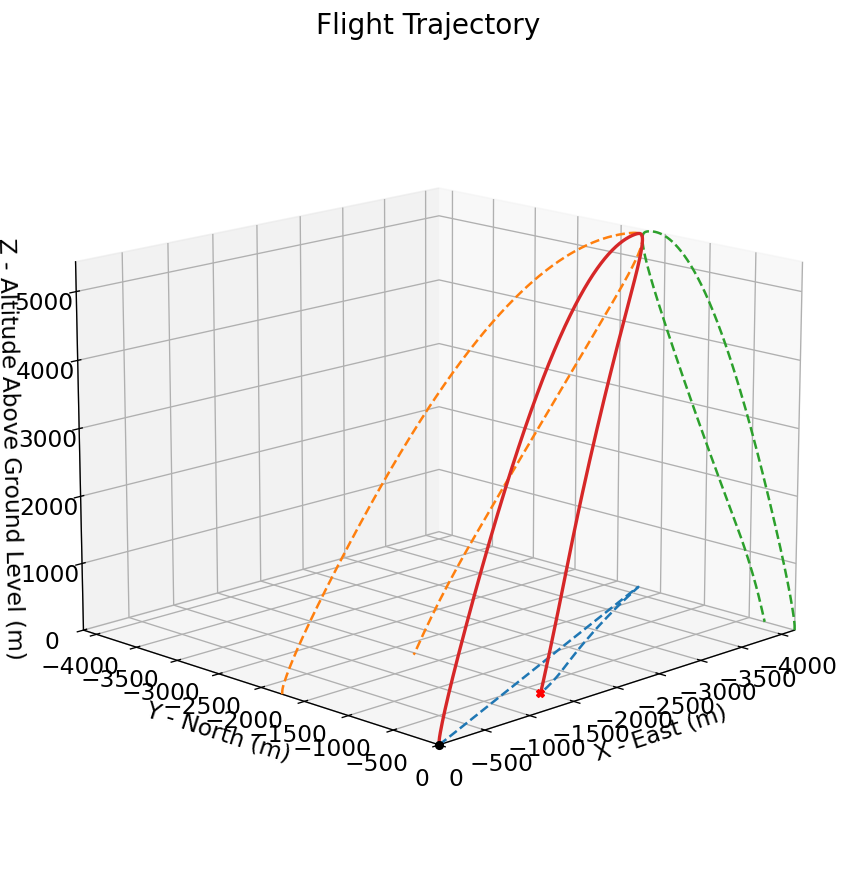



Trajectory Kinematic Plots



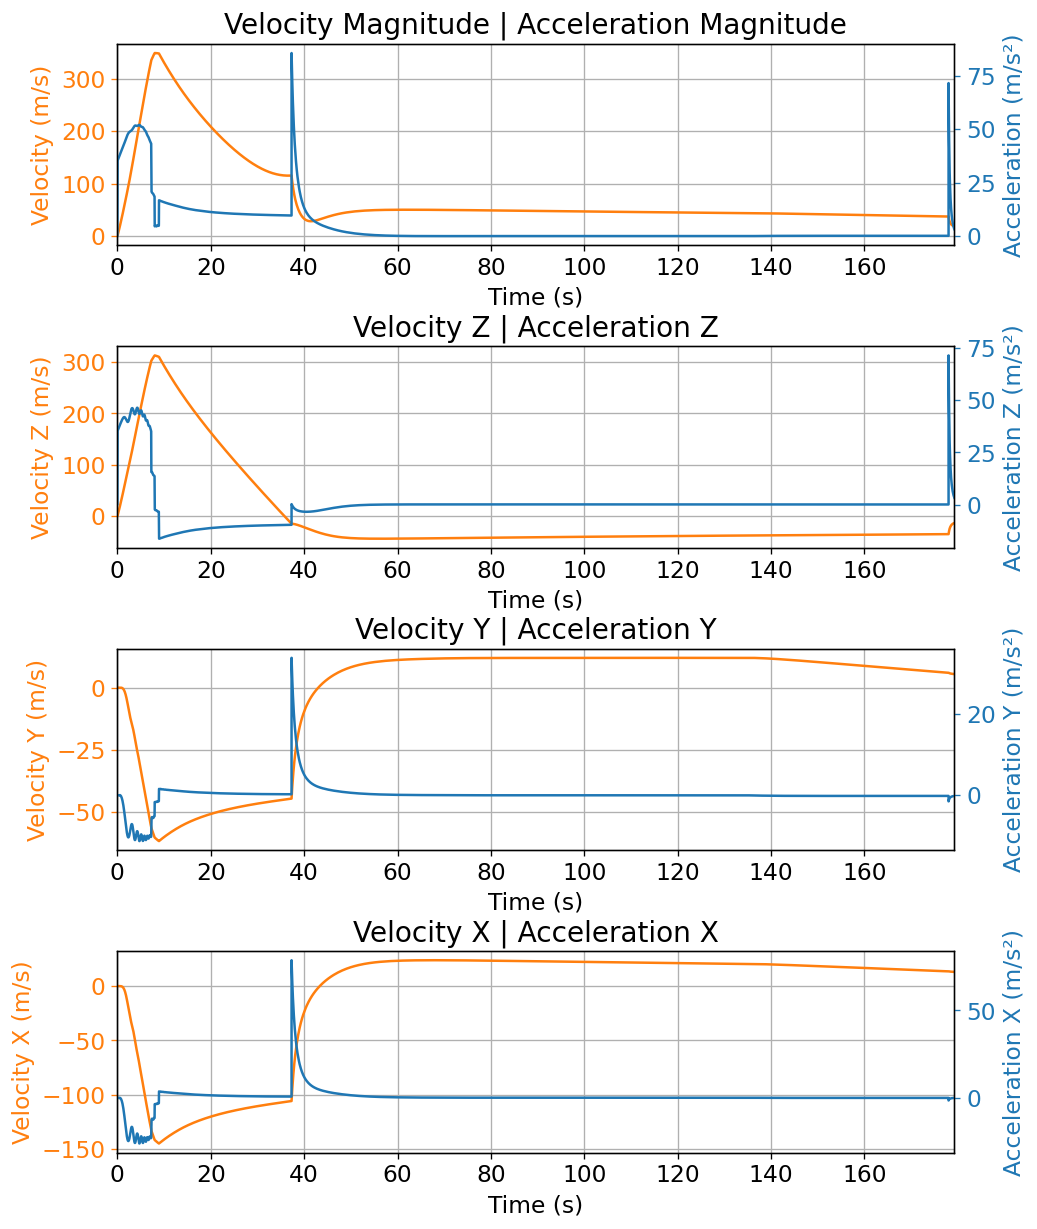



Angular Position Plots



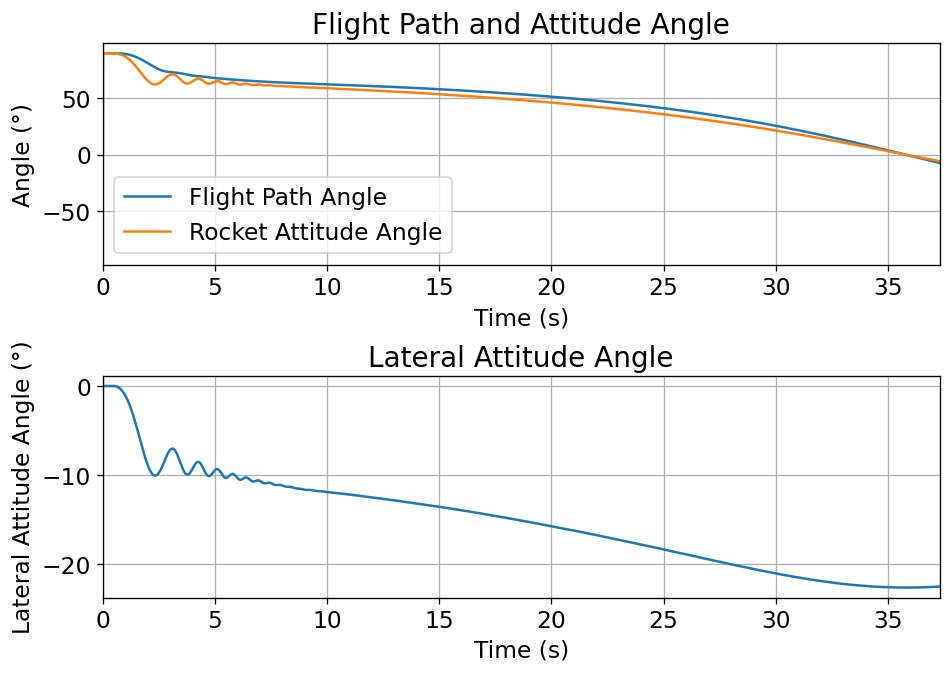



Path, Attitude and Lateral Attitude Angle plots



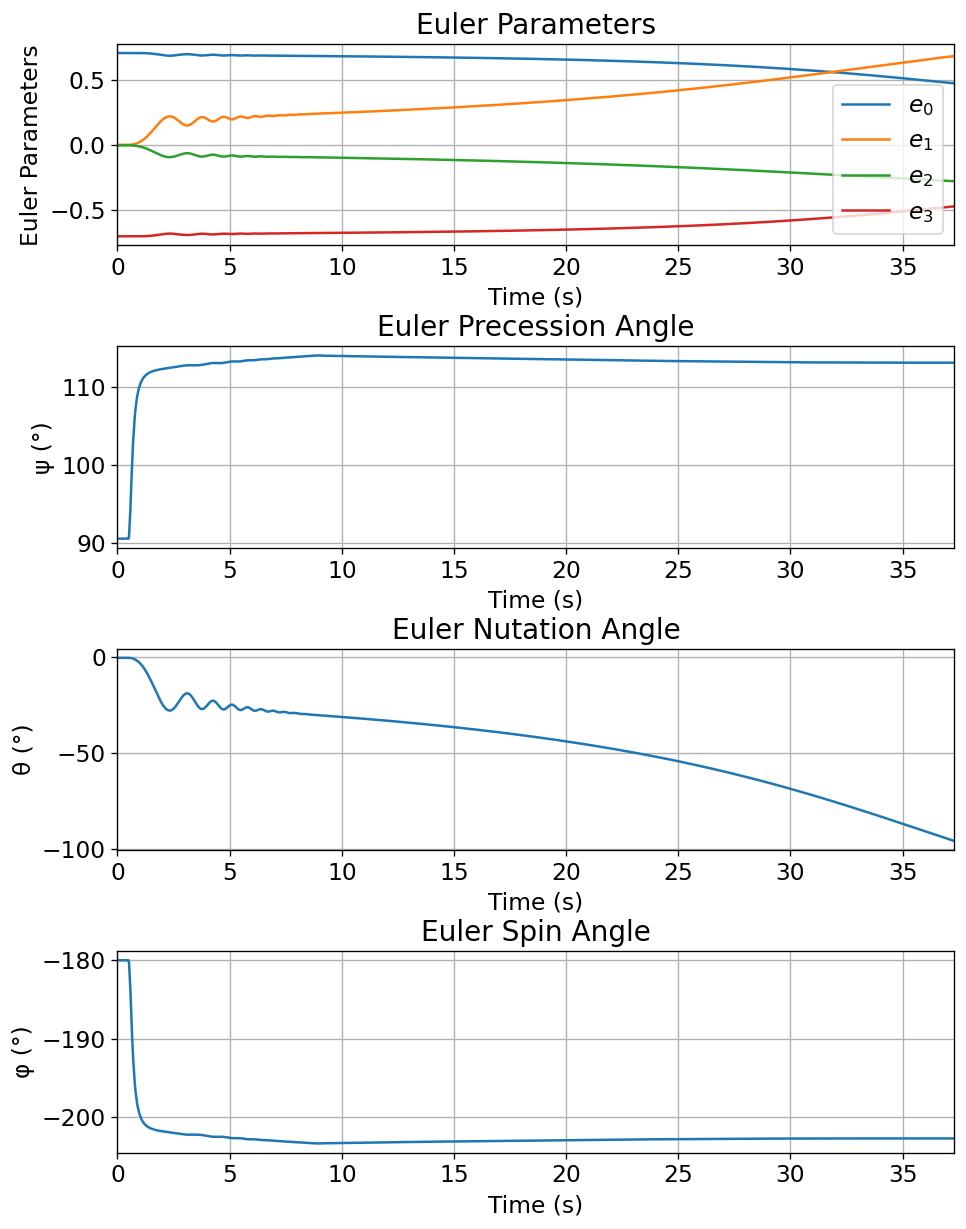



Trajectory Angular Velocity and Acceleration Plots



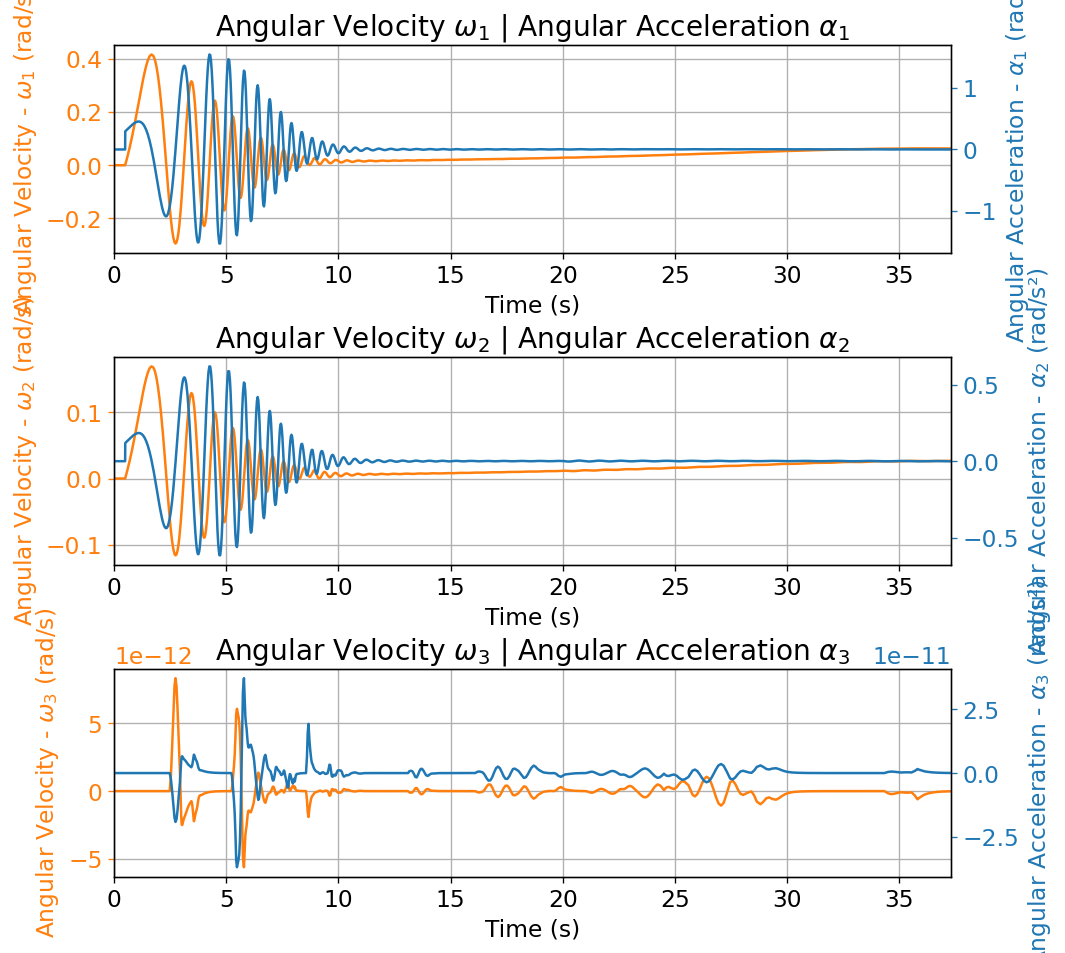



Aerodynamic Forces Plots



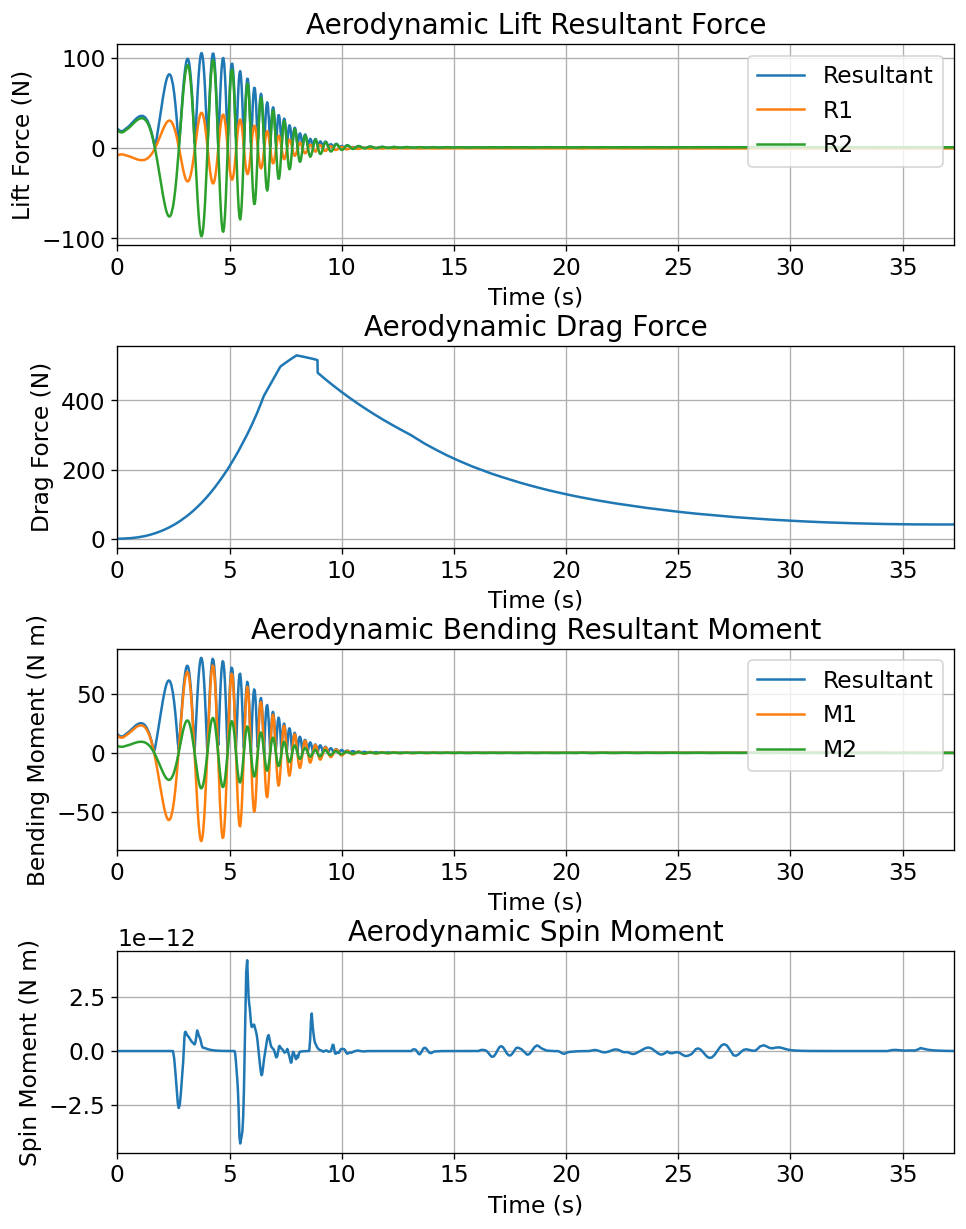



Rail Buttons Forces Plots



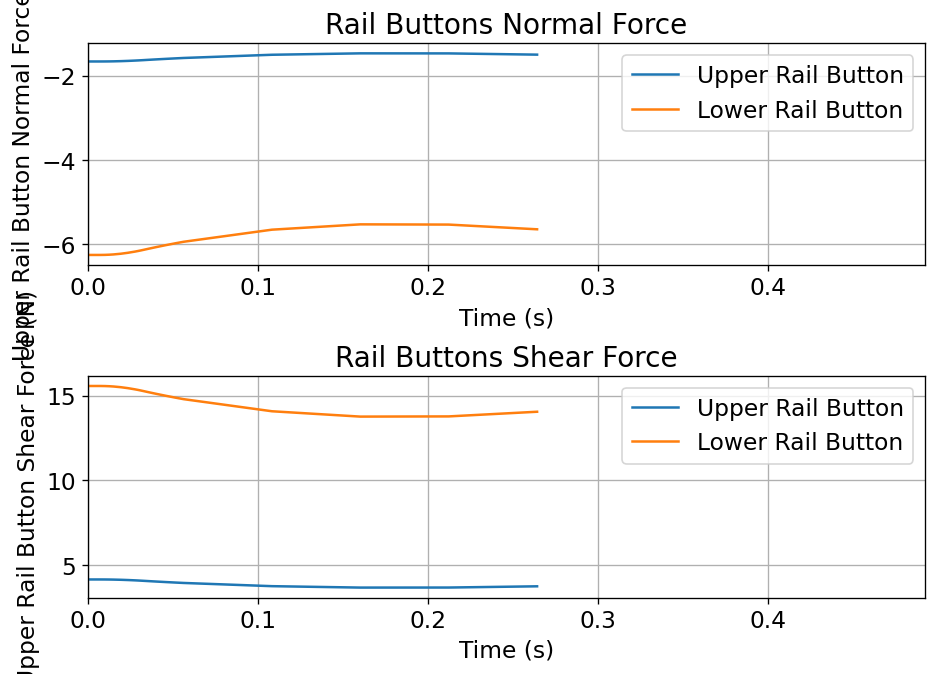



Trajectory Energy Plots



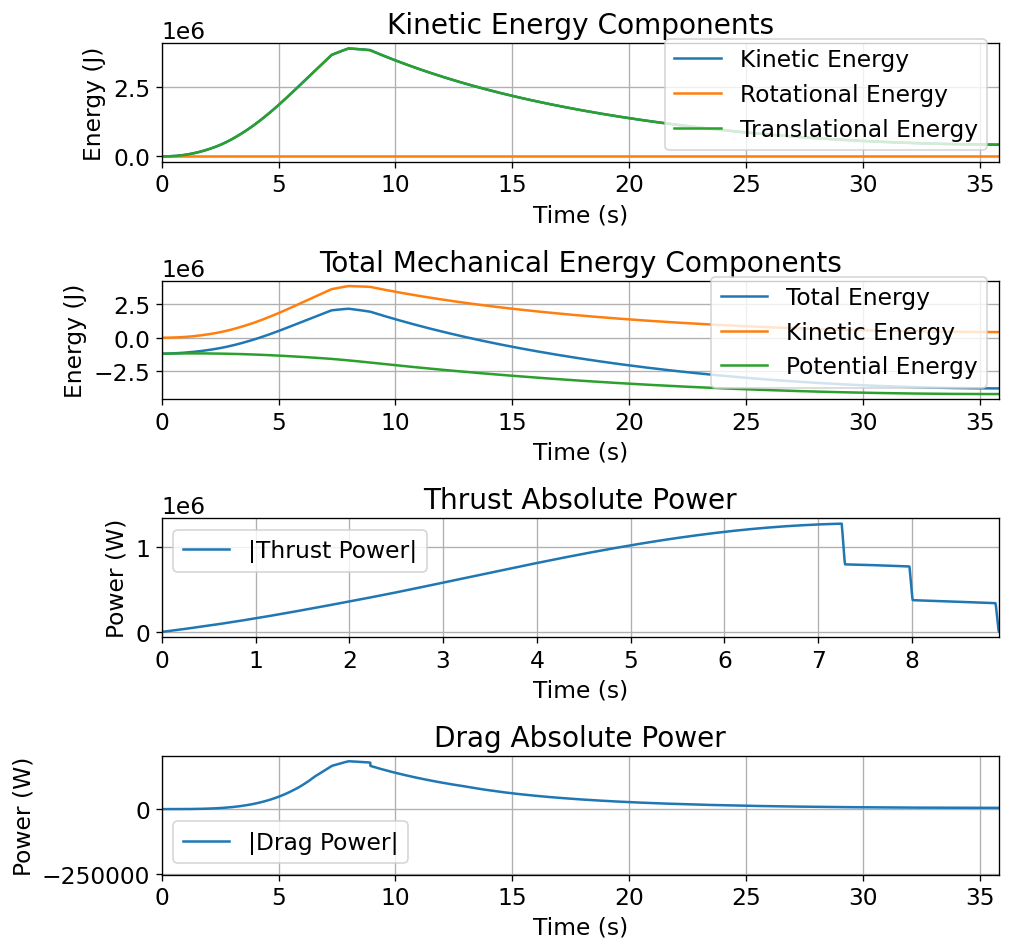



Trajectory Fluid Mechanics Plots



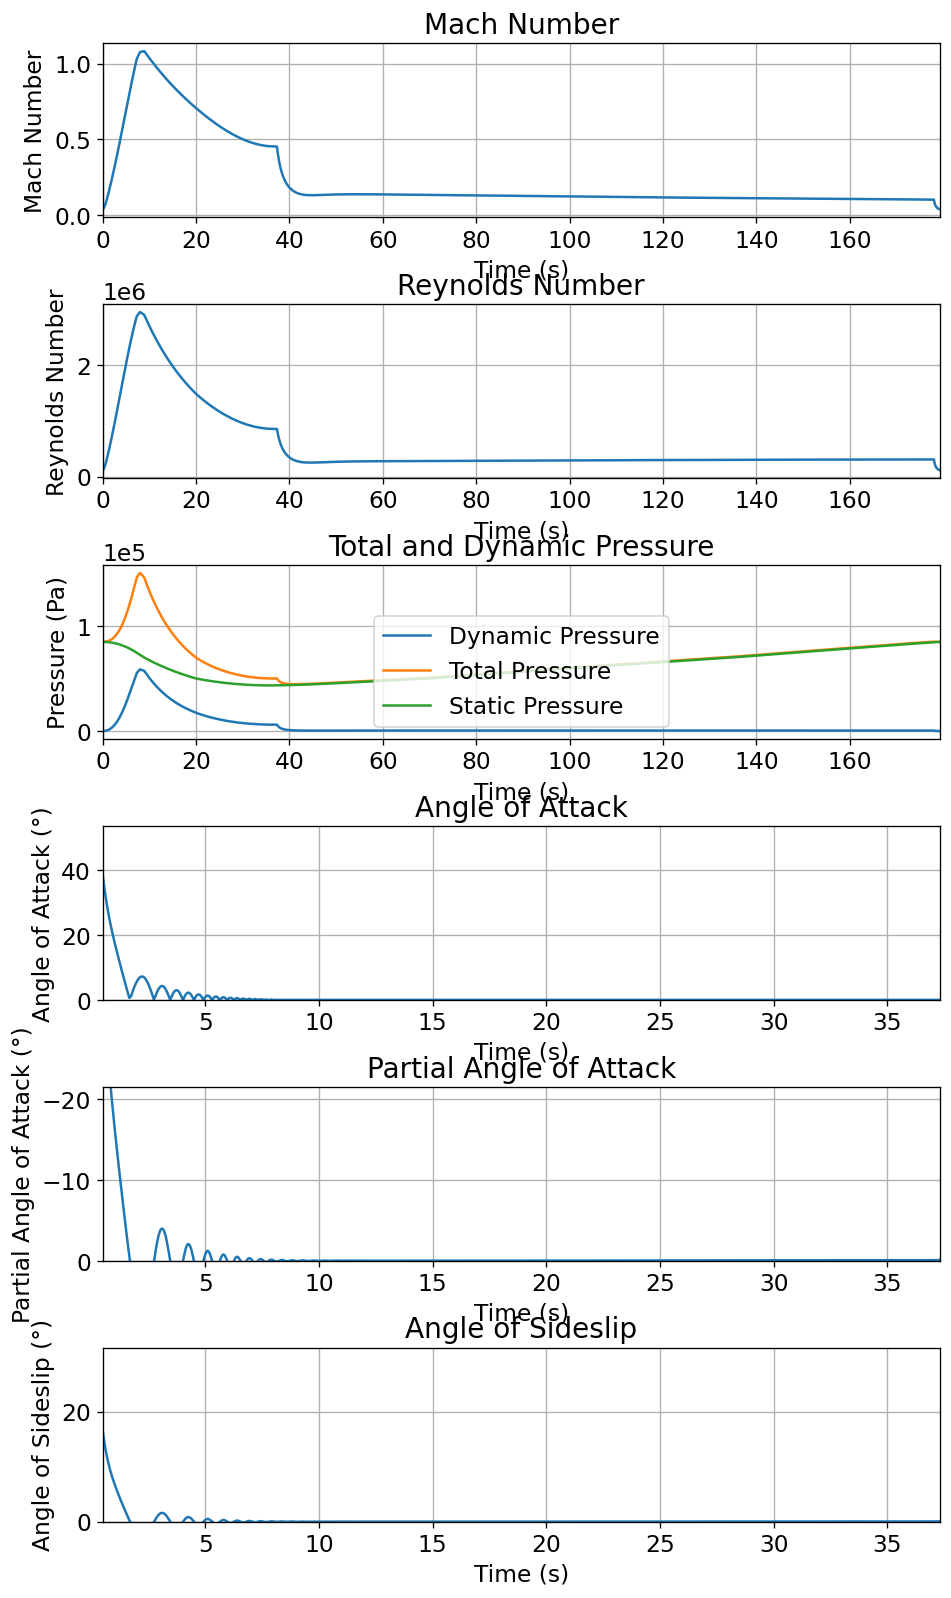



Trajectory Stability and Control Plots



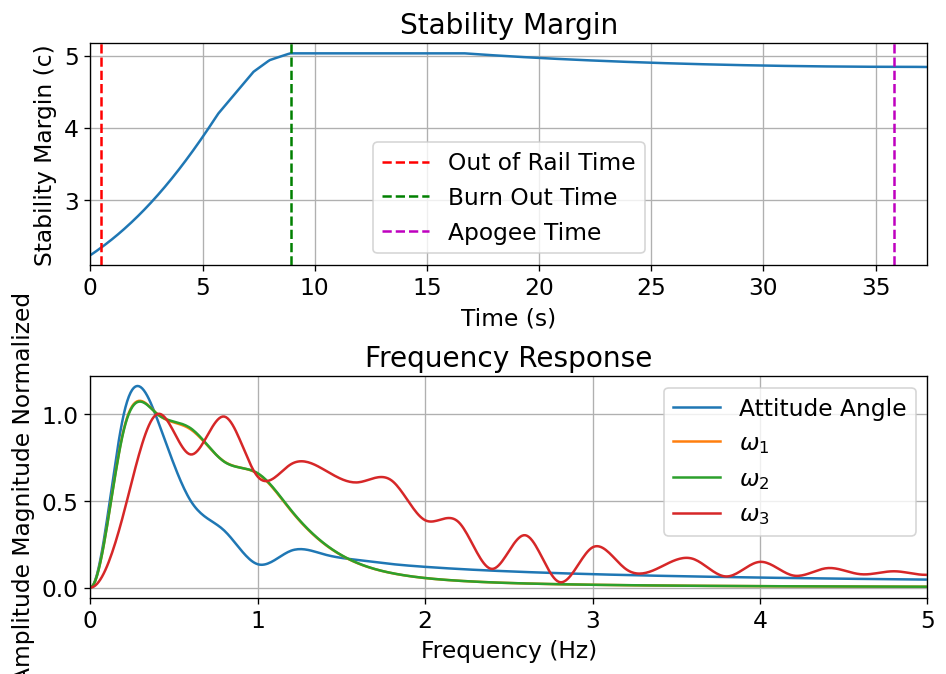



Rocket and Parachute Pressure Plots



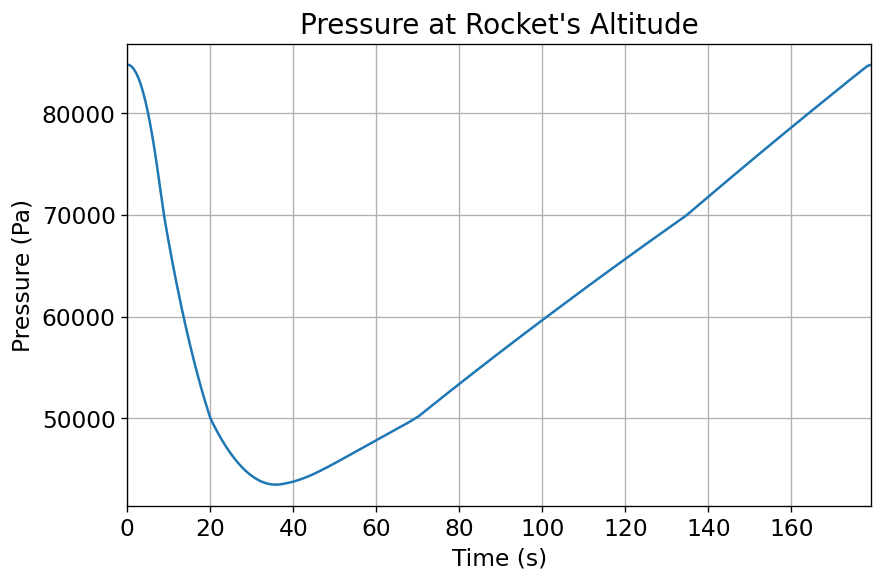


Parachute:  Drogue


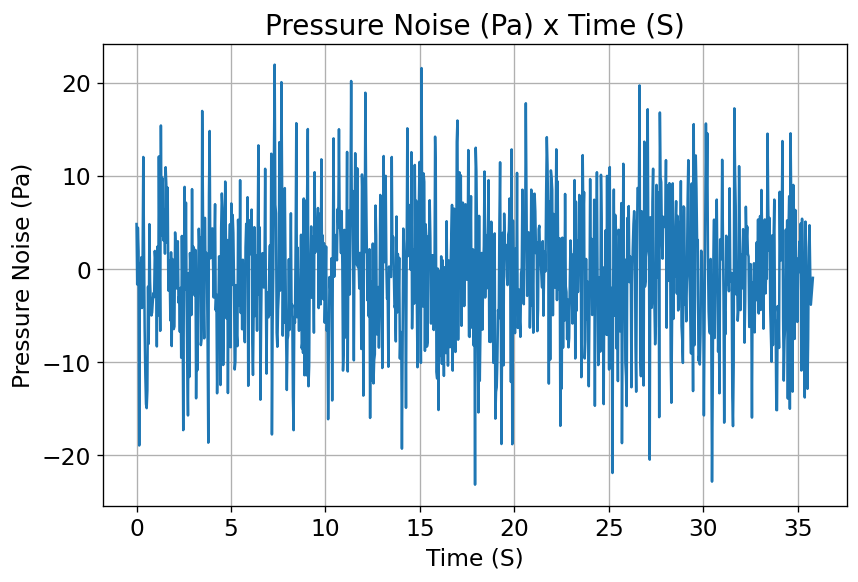

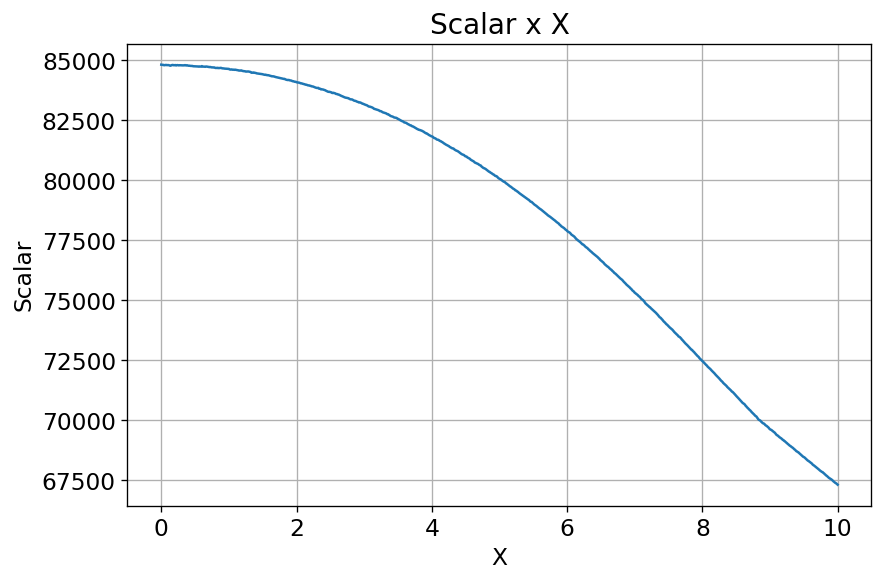

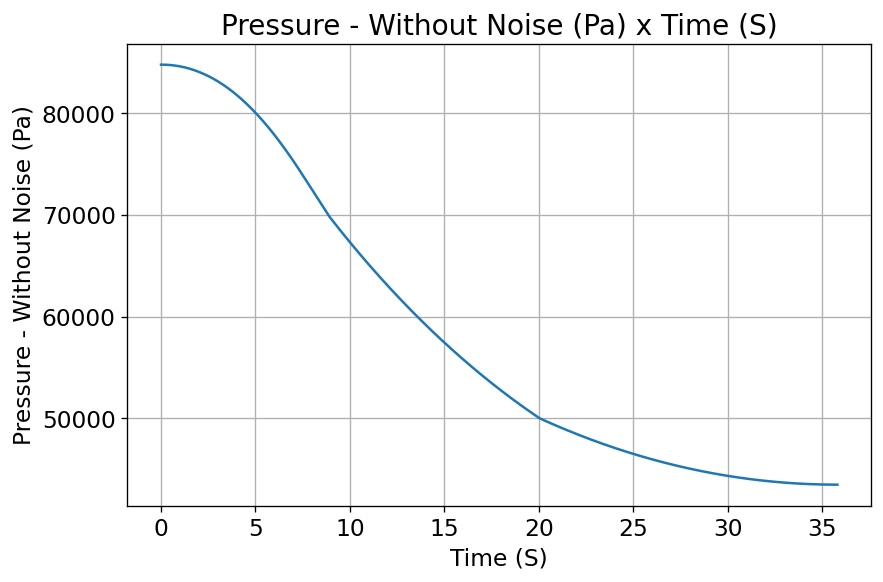


Parachute:  Main


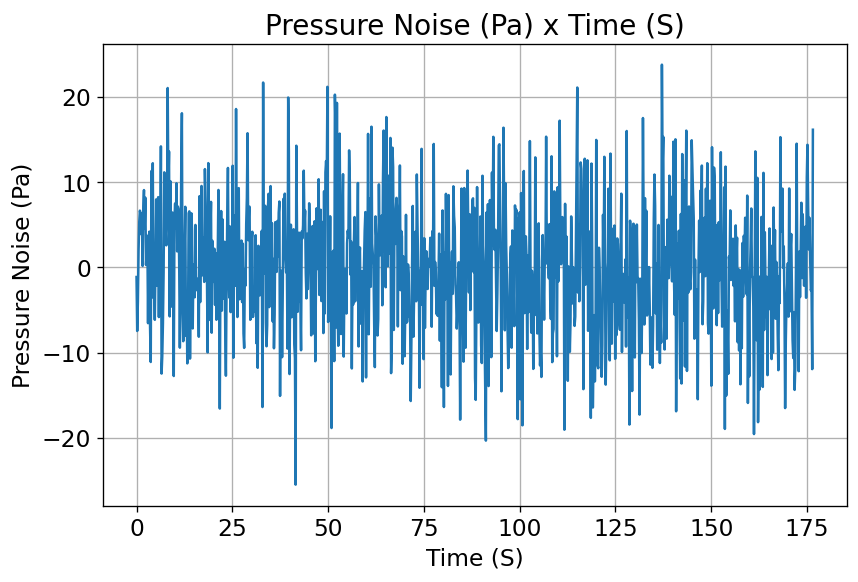

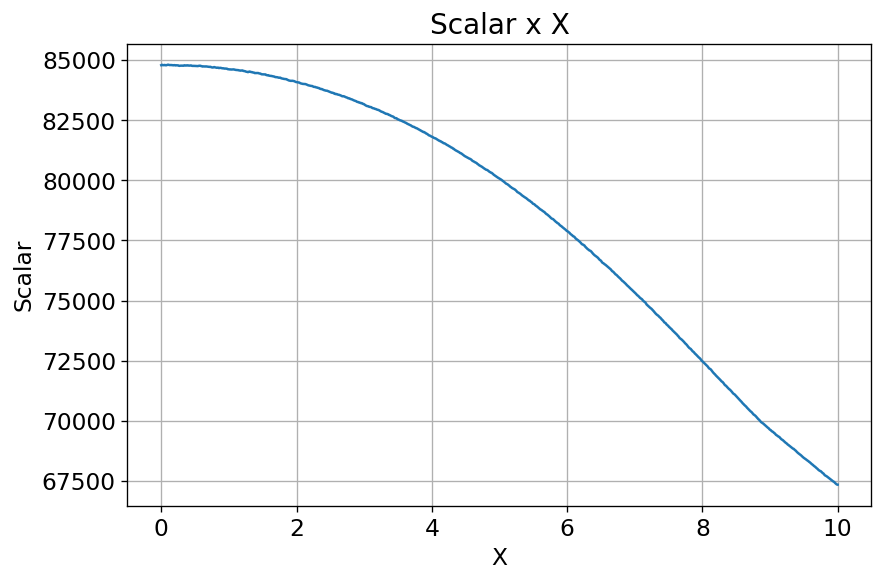

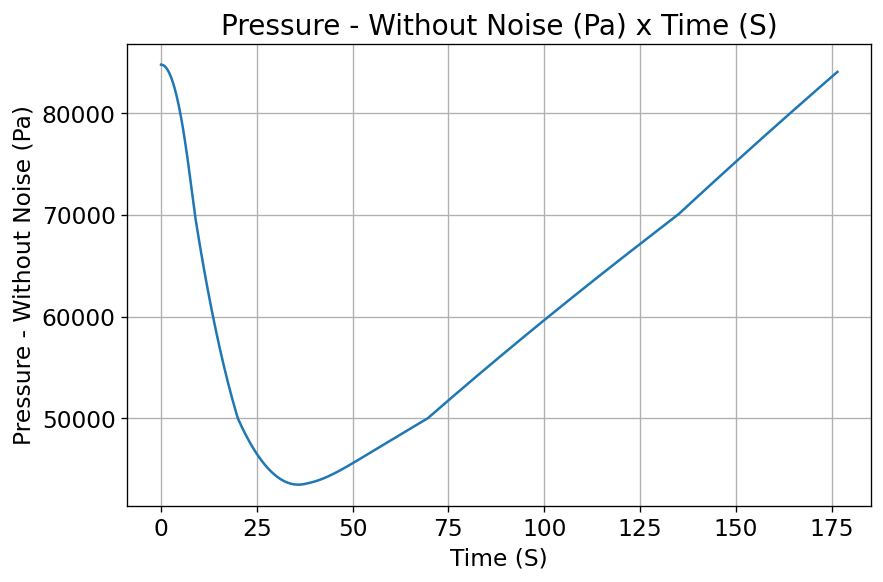

In [15]:
from rocketpy import plots
TestFlight.plots.all()


In [17]:
TestFlight.trajectory3d()

AttributeError: 'Flight' object has no attribute 'trajectory3d'